# Integrate GEX and ADT annotation and Trajectory analysis

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import os

In [2]:
plt.rcParams['figure.figsize'] = (8,8)

In [3]:
pd.options.display.max_columns=50

# Load ADT and RNA

In [4]:
os.getcwd()

'/home/jovyan/project/neurips2021-notebooks/notebooks/analysis/cite/s1d2'

In [5]:
os.chdir('/home/jovyan/project/')

In [6]:
adata_adt = sc.read('data/cite/proc_data/s1d2/s1d2_CITE_ADT_unmerged.h5ad')
adata_rna = sc.read('data/cite/proc_data/s1d2/s1d2_CITE_GEX_unmerged.h5ad')

In [7]:
print(adata_rna)
adata_adt

AnnData object with n_obs × n_vars = 5281 × 15508
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'size_factors', 'phase', 'leiden_final'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'


AnnData object with n_obs × n_vars = 7053 × 140
    obs: 'n_antibodies_by_counts', 'total_counts', 'iso_count', 'leiden_res0.5_sub', 'leiden_final'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'iso_count_fltr_colors', 'leiden', 'leiden_final_colors', 'leiden_res0.3_colors', 'leiden_res0.5_colors', 'leiden_res0.5_sub_colors', 'leiden_res0.8_colors', 'leiden_res1_colors', 'neighbors', 'pca', 'predicted_doublet_colors', 'rank_leiden_res0.5', 'rg_res0.5_sub', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# Merge datasets

Note on doublets: We filtered out doublet in the GEX processing. In CITE data, doublet removal seems to be less successful. Therefore, we rely on the doublet detection in the GEX data and remove them by getting the cells shared between both data sets.

In [8]:
common_barcodes = list(set(adata_rna.obs_names).intersection(adata_adt.obs_names))
adata_rna_sub = adata_rna[common_barcodes].copy()
adata_adt_sub = adata_adt[common_barcodes].copy()

In [9]:
adata_rna_sub.obs['adt_ann'] = adata_adt_sub.obs['leiden_final']
adata_adt_sub.obs['rna_ann'] = adata_rna_sub.obs['leiden_final']

# Merge leiden_finals

Here, we plot the celltype annotation based on the two modalities on the UMAP representation of each. Thereby we can assess how well the annotation of one modality matches the data structure in the other modality. This gives us a first overview where one modality containes additional substructure compared to the other.

For each celltype, we try to find the modality the represents a cleaner and more fine grained clustering. E.g. for T cells, the clusters are better separated in the CITE data (CD4+ vs CD8+), while for the Erythocyte linage additional substructure is found in the GEX data.

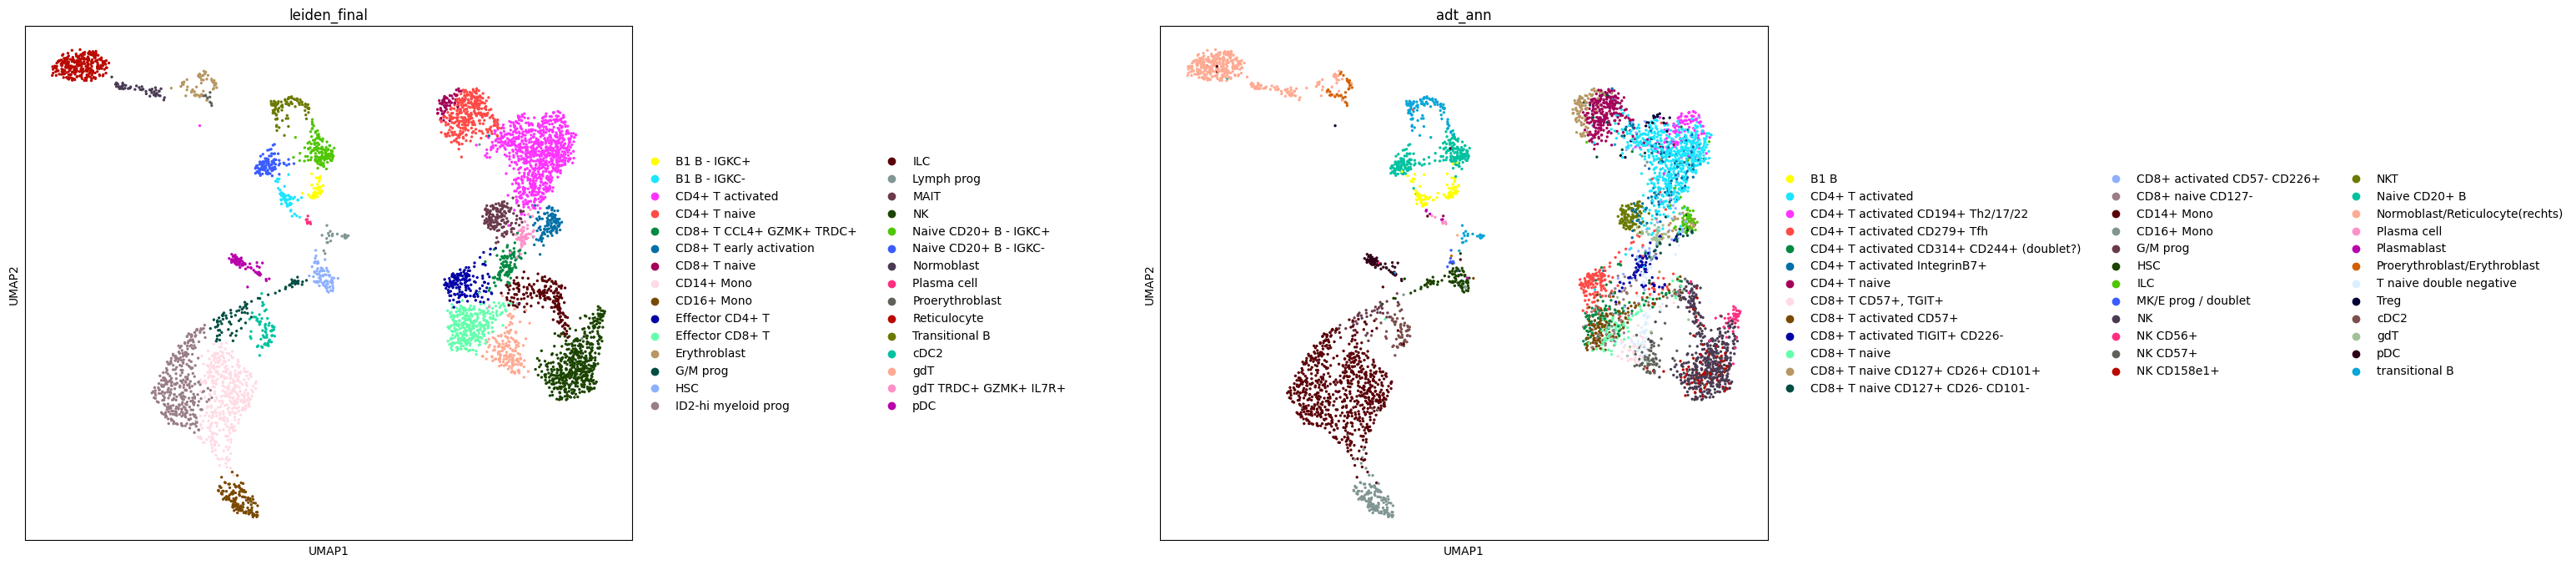

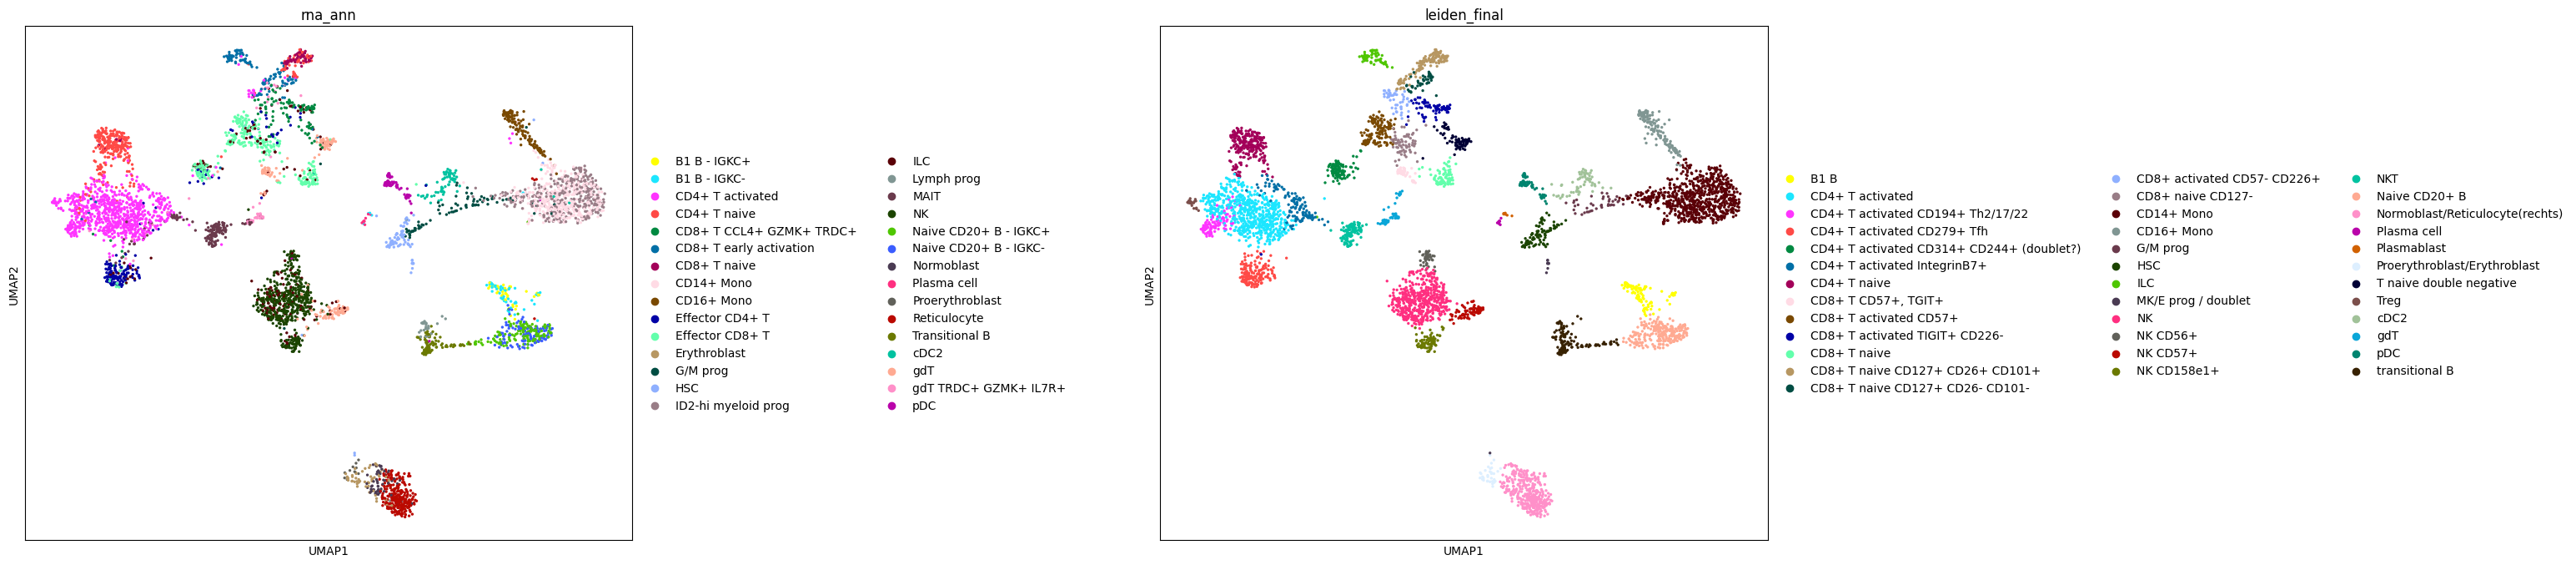

In [10]:
sc.pl.umap(adata_rna_sub, color=['leiden_final', 'adt_ann'], wspace=0.7)
sc.pl.umap(adata_adt_sub, color=['rna_ann', 'leiden_final'], wspace=0.7)

In [11]:
col_map_adt = {a:b for a,b in zip(adata_adt_sub.obs['leiden_final'].cat.categories, adata_adt_sub.uns['leiden_final_colors'],)}
col_map_rna = {a:b for a,b in zip(adata_rna_sub.obs['leiden_final'].cat.categories, adata_rna_sub.uns['leiden_final_colors'])}


adata_rna_sub.uns['adt_ann_colors'] = [col_map_adt[ct] for ct in  adata_rna_sub.obs['adt_ann'].cat.categories]
adata_adt_sub.uns['rna_ann_colors'] = [col_map_rna[ct] for ct in  adata_adt_sub.obs['rna_ann'].cat.categories]

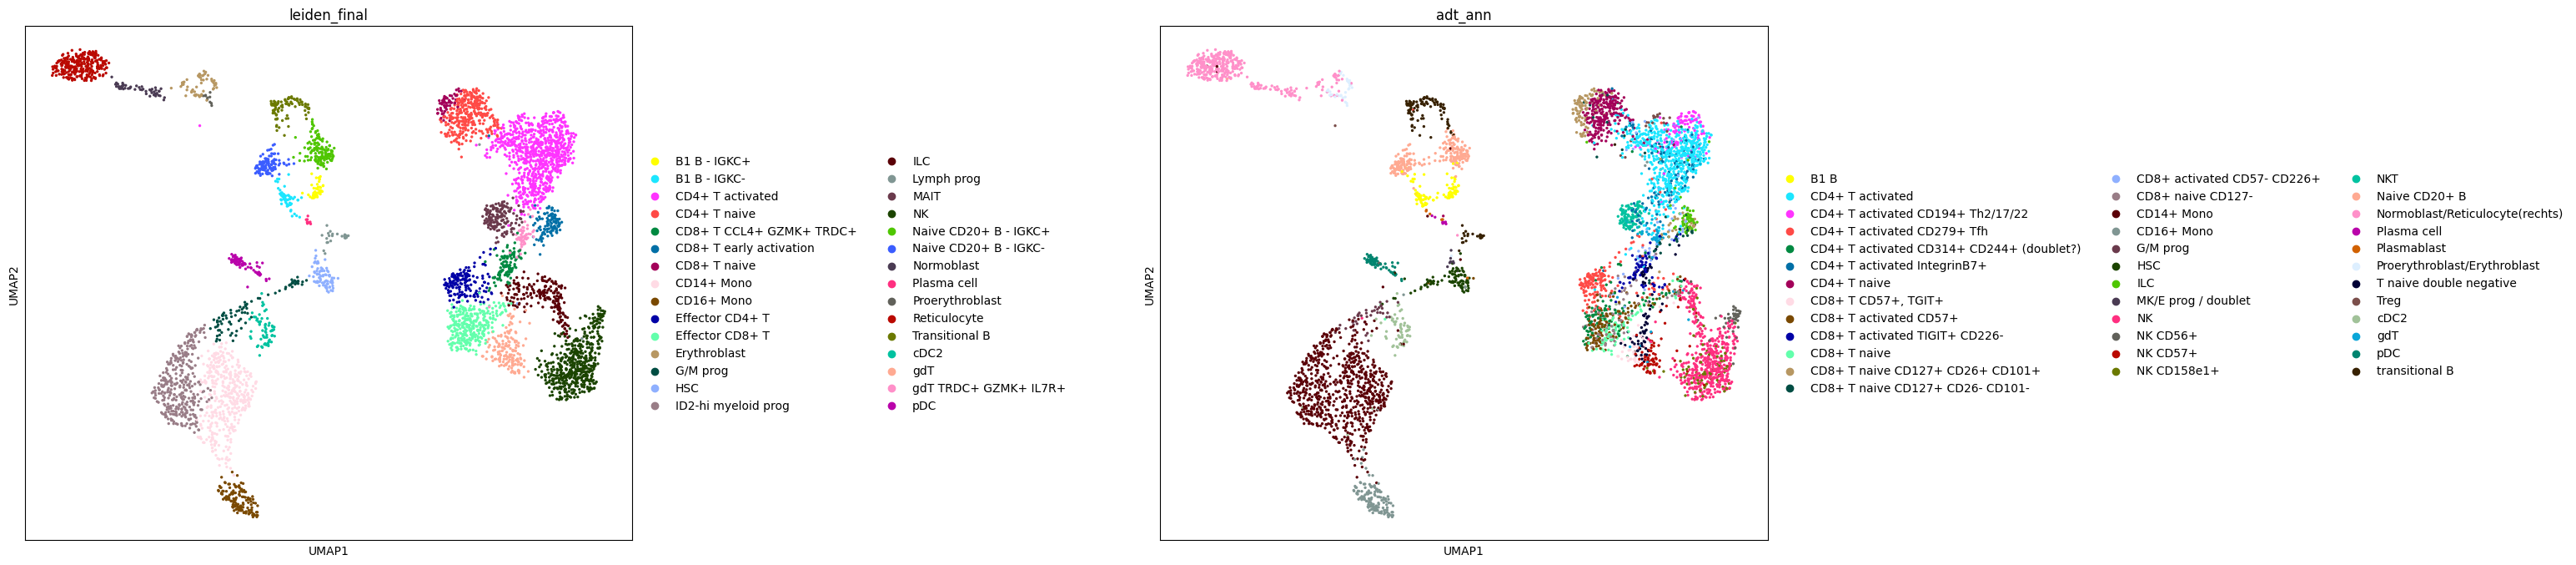

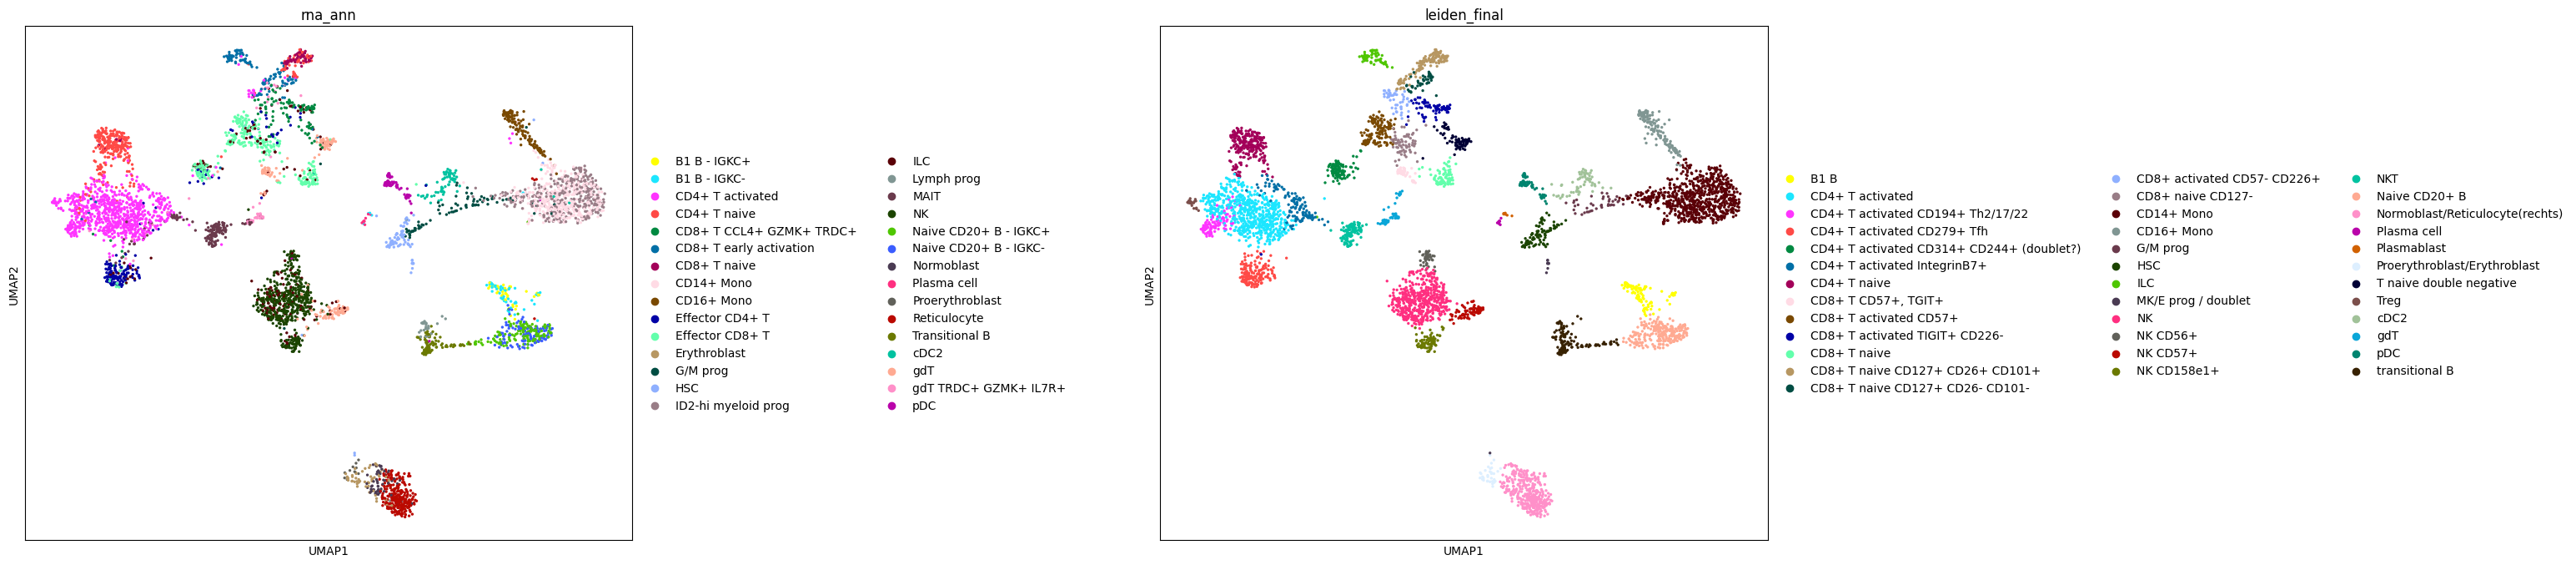

In [12]:
sc.pl.umap(adata_rna_sub, color=['leiden_final', 'adt_ann'], wspace=0.7)
sc.pl.umap(adata_adt_sub, color=['rna_ann', 'leiden_final'], wspace=0.7)

We then decide which modality should be the more determining one for each cell type:
- B cells from RNA 
- plasma cell & plasmablast from ADT
- MK/E prog / doublet from ADT -> MK/E prog
- progenitors RNA
- cDC2 RNA
- pDC ADT
- CD16+ Mono ADT
- CD14+ Mono RNA
- ID2-hi myeloid prog RNA
- erythrocyte lineage from RNA
- Naive T cells from ADT


T & NK cells from ADT:
- 'NK CD56+': 'gdT CD56+'
- 'NK CD57+': 'gdT Vd1 CD57+'
- 'gdT': 'gdT TCRVD2+'
- 'T naive double negative':'gdT CD158b+ CD11c+'


- 'CD4+ T activated CD279+ Tfh': 'CD4+ T activated CD279+'
- 'CD4+ T naive': 'CD4+ T naive'
- 'CD4+ T activated':'CD4+ T activated'
- 'CD4+ T activated CD194+ Th2/17/19': 'CD4+ T activated CD194+'
- 'Treg': 'T reg'
- 'CD4+ T activated integrinB7+':'CD4+ T activated integrinB7+'
- 'CD4+ T activated CD314+ CD244+ (doublet?)': 'CD4+ T CD45RA+ CD314+'
- 'NKT': 'MAIT'

- 'CD8+ T naive':'CD8+ T CD45RA+ CD56+'
- 'CD8+ T naive CD127-':'CD8+ T CD45RA+ CD127-'
- 'CD8+ T activated CD57+':'CD8+ T activated CD57+'
- 'CD8+ T CD57+, TGIT+': 'CD8+ T CD158b+ CD57+ TIGIT+'
- 'CD8+ T naive CD127+ CD26+ CD101+':'CD8+ T naive CD127+ CD26+ CD101+'
- 'CD8+ T naive CD127+ CD26- CD101-':'CD8+ T naive CD127+ CD26- CD101-'
- 'CD8+ T activated TIGIT+ CD226-':'CD8+ T activated TIGIT+ CD226-'
- 'CD8+ T activated CD57- CD226+':'CD8+ T activated CD57- CD226+'
- 'ILC': 'ILC1'
- 'NK CD158e1+': 'NK CD158e1+'

Combination:
- NK in ADT & ILC in RNA => ILC
- rest ILC in RNA -> low Quality!
- rest NK from ADT

## Crosstab leiden_finals

We now dive into details and check which cell type in one modality corresponds to the celltype in the second.

We look for differing annotations and check those with marker genes for each modality below. Thereby, we take a final decision for each celltype, which annotation we will use.

In [13]:
# Note: First argument corresponds to rows (here, RNA), second argument to columns (here: ADT)
pd.crosstab(adata_rna_sub.obs['leiden_final'], adata_adt_sub.obs['leiden_final'])

leiden_final              B1 B  CD4+ T activated  \
leiden_final                                       
B1 B - IGKC+                41                 0   
B1 B - IGKC-                49                 0   
CD4+ T activated             0               586   
CD4+ T naive                 0                23   
CD8+ T CCL4+ GZMK+ TRDC+     0                 3   
CD8+ T early activation      0                 4   
CD8+ T naive                 0                 0   
CD14+ Mono                   0                 0   
CD16+ Mono                   0                 0   
Effector CD4+ T              0                 4   
Effector CD8+ T              0                 0   
Erythroblast                 0                 0   
G/M prog                     0                 0   
HSC                          0                 0   
ID2-hi myeloid prog          0                 0   
ILC                          0                 0   
Lymph prog                   0                 0   
MAIT                         0                12   
NK                           0                 0   
Naive CD20+ B - IGKC+        2                 0   
Naive CD20+ B - IGKC-        4                 0   
Normoblast                   0                 0   
Plasma cell                  0                 0   
Proerythroblast              0                 0   
Reticulocyte                 0                 0   
Transitional B               0                 0   
cDC2                         0                 0   
gdT                          0                 0   
gdT TRDC+ GZMK+ IL7R+        0                 8   
pDC                          0                 0   

leiden_final              CD4+ T activated CD194+ Th2/17/22  \
leiden_final                                                  
B1 B - IGKC+                                              0   
B1 B - IGKC-                                              0   
CD4+ T activated                                        105   
CD4+ T naive                                              0   
CD8+ T CCL4+ GZMK+ TRDC+                                  0   
CD8+ T early activation                                   0   
CD8+ T naive                                              0   
CD14+ Mono                                                0   
CD16+ Mono                                                0   
Effector CD4+ T                                           0   
Effector CD8+ T                                           0   
Erythroblast                                              0   
G/M prog                                                  0   
HSC                                                       0   
ID2-hi myeloid prog                                       0   
ILC                                                       0   
Lymph prog                                                0   
MAIT                                                      0   
NK                                                        0   
Naive CD20+ B - IGKC+                                     0   
Naive CD20+ B - IGKC-                                     0   
Normoblast                                                0   
Plasma cell                                               0   
Proerythroblast                                           0   
Reticulocyte                                              0   
Transitional B                                            0   
cDC2                                                      0   
gdT                                                       0   
gdT TRDC+ GZMK+ IL7R+                                     0   
pDC                                                       0   

leiden_final              CD4+ T activated CD279+ Tfh  \
leiden_final                                            
B1 B - IGKC+                                        0   
B1 B - IGKC-                                        0   
CD4+ T activated                                    4   
CD4+ T naive                     

### Load marker genes

In case in your analysis other markers showed up, we can add them here as well

In [21]:
#RNA
marker_genes_rna = {
    'CD14+ Mono': ['FCN1', 'CD14'],
    'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
    'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'FOS', 'JUN', 'EGR1', 'KLF4', 'PLAUR'],
    'cDC1': ['CLEC9A', 'CADM1'],
    'cDC2': ['CLEC10A', 'FCER1A', 'CST3', 'COTL1', 'LYZ', 'DMXL2'], # Note: DMXL2 should be negative
    'Reticulocyte': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'], # TFRC negative
    'Normoblast': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],  # TFRC positive
    'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
    'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers   # CRACD as well, but not present in data
    'NK': ['GNLY', 'NKG7', 'CD247', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A'], # GRIK4 as well, but not present in data
    'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
    'Lymph prog': ['IGLL1', 'VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT'],  # new: STMN1
    'Naive CD20+ B - IGKC+':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'],
    'Naive CD20+ B - IGKC-':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'], # IGKC negative
    'B1 B - IGKC+':['MS4A1', 'SSPN', 'ITGB1','IGKC', 'EPHA4', 'COL4A4', 'PRDM1', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM'],# Note IGHD and IGHM are negative markers #ZNF215 not in data
    'B1 B - IGKC-':['MS4A1', 'SSPN', 'ITGB1', 'EPHA4', 'COL4A4', 'PRDM1', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM', 'IGKC'],# Note IGKC, IGHD and IGHM are negative markers #ZNF215 not in data
    'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
    'Plasma cell': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
    'Plasmablast': ['XBP1', 'PRDM1', 'PAX5'],  # Note PAX5 is a negative marker   # RF4 as well, but not present in data
    'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
    'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7'],
    'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
    'T activation': ['CD69', 'CD38'], # CD69 much better marker!
    'T naive': ['LEF1', 'CCR7', 'TCF7'],
    'Effector CD4+ T': ['KLRB1', 'CD4', 'PDCD1', 'TNF'],
    'Effector CD8+ T': ['KLRK1', 'GZMH', 'CD8A', 'CD8B'],
    'MAIT': ['KLRB1', 'CD8A', 'GZMK', 'IL7R'],
    'gdT': ['KLRC2', 'KLRF1', 'FCGR3A', 'GZMB', 'GZMH'],
    'pDC': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
    'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R', 'PRTN3'], 
    'HSC': ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2'], 
    'MK/E prog': ['ZNF385D', 'ITGA2B', 'PLCB1'], # 'RYR3' as well,  but not present in data
}
#ADT
marker_genes_adt = {
    
    'CD14+ Mono': ['CD14', 'CD11b', 'CD62P'],
    'CD16+ Mono': ['CD11c', 'CD172a', 'CD88', 'CD85j'],
    'cDC2': ['CD11c',  'CD1c', 'FceRIa'],
    'pDCs': ['CD303', 'CD304'], 
    
    #Ery linage
    'Proerythroblast': ['CD105'],
    'Erythroblast': ['CD82', 'CD71'], # CD82 also in B
    'Normoblast/Reticulocyte': ['CD71'], 
    #'Reticulocyte': ['CD71'],  

    # B linage
    'Naive CD20+ B': ['IgD'],
    'B1 B': ['CD40', 'CD35', 'CD268', 'IgD'], # (IgD- !)
    'Transitional B': ['CD38', 'CD24'], # 'CD24', 'CD81', 'CD9'
    'Plasma cells': ['CD63', 'CD319'], 
    'Plasmablast': ['CD39', 'CD319'], # CD86

    # T linage
    'CD4+ T activated': ['CD4', 'CD45RO', 'CD25'], # CD25 negative, since these should be T regs
    'Treg':['CD25', 'CD39'],
    'CD4+ T naive': ['CD4', 'CD45RA'],
    
    'CD8+ T activated TIGIT+': ['CD8', 'CD45RO', 'TIGIT'],
    'CD8+ T activated CD69+': ['CD8', 'CD45RO', 'CD69'],
    'CD8+ T naive': ['CD8', 'CD45RA'],

    'gdT':['TCRVd2', 'CD161'],
    
    'NKT': ['TCRVa7.2'], #not 100% sure

    'NK': ['CD56', 'CD94', 'CD335'],  # 'CD57'?
    
    # Progenitors
    'ILC': ['CD127', 'CD103'], # CD103? also mentioned as Treg
    'MK/E prog':['CD112', 'CD105', 'CD352'],
    'HSC': ['CD13', 'CD155', 'CD112'],
    'Lymph prog':['CD112', 'CD81'], # close to HSC
    'G/M prog':['CD112', 'CD86']

}

In [22]:
marker_genes_rna.keys()

dict_keys(['CD14+ Mono', 'CD16+ Mono', 'ID2-hi myeloid prog', 'cDC1', 'cDC2', 'Reticulocyte', 'Normoblast', 'Erythroblast', 'Proerythroblast', 'NK', 'ILC', 'Lymph prog', 'Naive CD20+ B - IGKC+', 'Naive CD20+ B - IGKC-', 'B1 B - IGKC+', 'B1 B - IGKC-', 'Transitional B', 'Plasma cell', 'Plasmablast', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'T activation', 'T naive', 'Effector CD4+ T', 'Effector CD8+ T', 'MAIT', 'gdT', 'pDC', 'G/M prog', 'HSC', 'MK/E prog'])

In [23]:
marker_genes_adt.keys()

dict_keys(['CD14+ Mono', 'CD16+ Mono', 'cDC2', 'pDCs', 'Proerythroblast', 'Erythroblast', 'Normoblast/Reticulocyte', 'Naive CD20+ B', 'B1 B', 'Transitional B', 'Plasma cells', 'Plasmablast', 'CD4+ T activated', 'Treg', 'CD4+ T naive', 'CD8+ T activated TIGIT+', 'CD8+ T activated CD69+', 'CD8+ T naive', 'gdT', 'NKT', 'NK', 'ILC', 'MK/E prog', 'HSC', 'Lymph prog', 'G/M prog'])

- B cells from RNA 
- plasma cell & plasmablast from ADT
- MK/E prog / doublet from ADT -> MK/E prog
- progenitors RNA
- cDC2 RNA
- pDC ADT
- CD16+ Mono ADT
- CD14+ Mono RNA
- ID2-hi myeloid prog RNA
- erythrocyte lineage from RNA
- Naive T cells from ADT


T & NK cells from ADT:
- 'NK CD56+': 'gdT CD56+'
- 'NK CD57+': 'gdT Vd1 CD57+'
- 'gdT': 'gdT TCRVD2+'
- 'T naive double negative':'gdT CD158b+ CD11c+'


- 'CD4+ T activated CD279+ Tfh': 'CD4+ T activated CD279+'
- 'CD4+ T naive': 'CD4+ T naive'
- 'CD4+ T activated':'CD4+ T activated'
- 'CD4+ T activated CD194+ Th2/17/19': 'CD4+ T activated CD194+'
- 'Treg': 'T reg'
- 'CD4+ T activated integrinB7+':'CD4+ T activated integrinB7+'
- 'CD4+ T activated CD314+ CD244+ (doublet?)': 'CD4+ T CD45RA+ CD314+'
- 'NKT': 'MAIT'

- 'CD8+ T naive':'CD8+ T CD45RA+ CD56+'
- 'CD8+ T naive CD127-':'CD8+ T CD45RA+ CD127-'
- 'CD8+ T activated CD57+':'CD8+ T activated CD57+'
- 'CD8+ T CD57+, TGIT+': 'CD8+ T CD158b+ CD57+ TIGIT+'
- 'CD8+ T naive CD127+ CD26+ CD101+':'CD8+ T naive CD127+ CD26+ CD101+'
- 'CD8+ T naive CD127+ CD26- CD101-':'CD8+ T naive CD127+ CD26- CD101-'
- 'CD8+ T activated TIGIT+ CD226-':'CD8+ T activated TIGIT+ CD226-'
- 'CD8+ T activated CD57- CD226+':'CD8+ T activated CD57- CD226+'
- 'ILC': 'ILC1'
- 'NK CD158e1+': 'NK CD158e1+'

Combination:
- NK in ADT & ILC in RNA => ILC
- rest ILC in RNA -> low Quality!
- rest NK from ADT

### Check out specific celltypes

Check out cell type markers in each modality to see which clusters are more disctinct. Here we plot RNA and ADT markers on both representations.

Markers on RNA


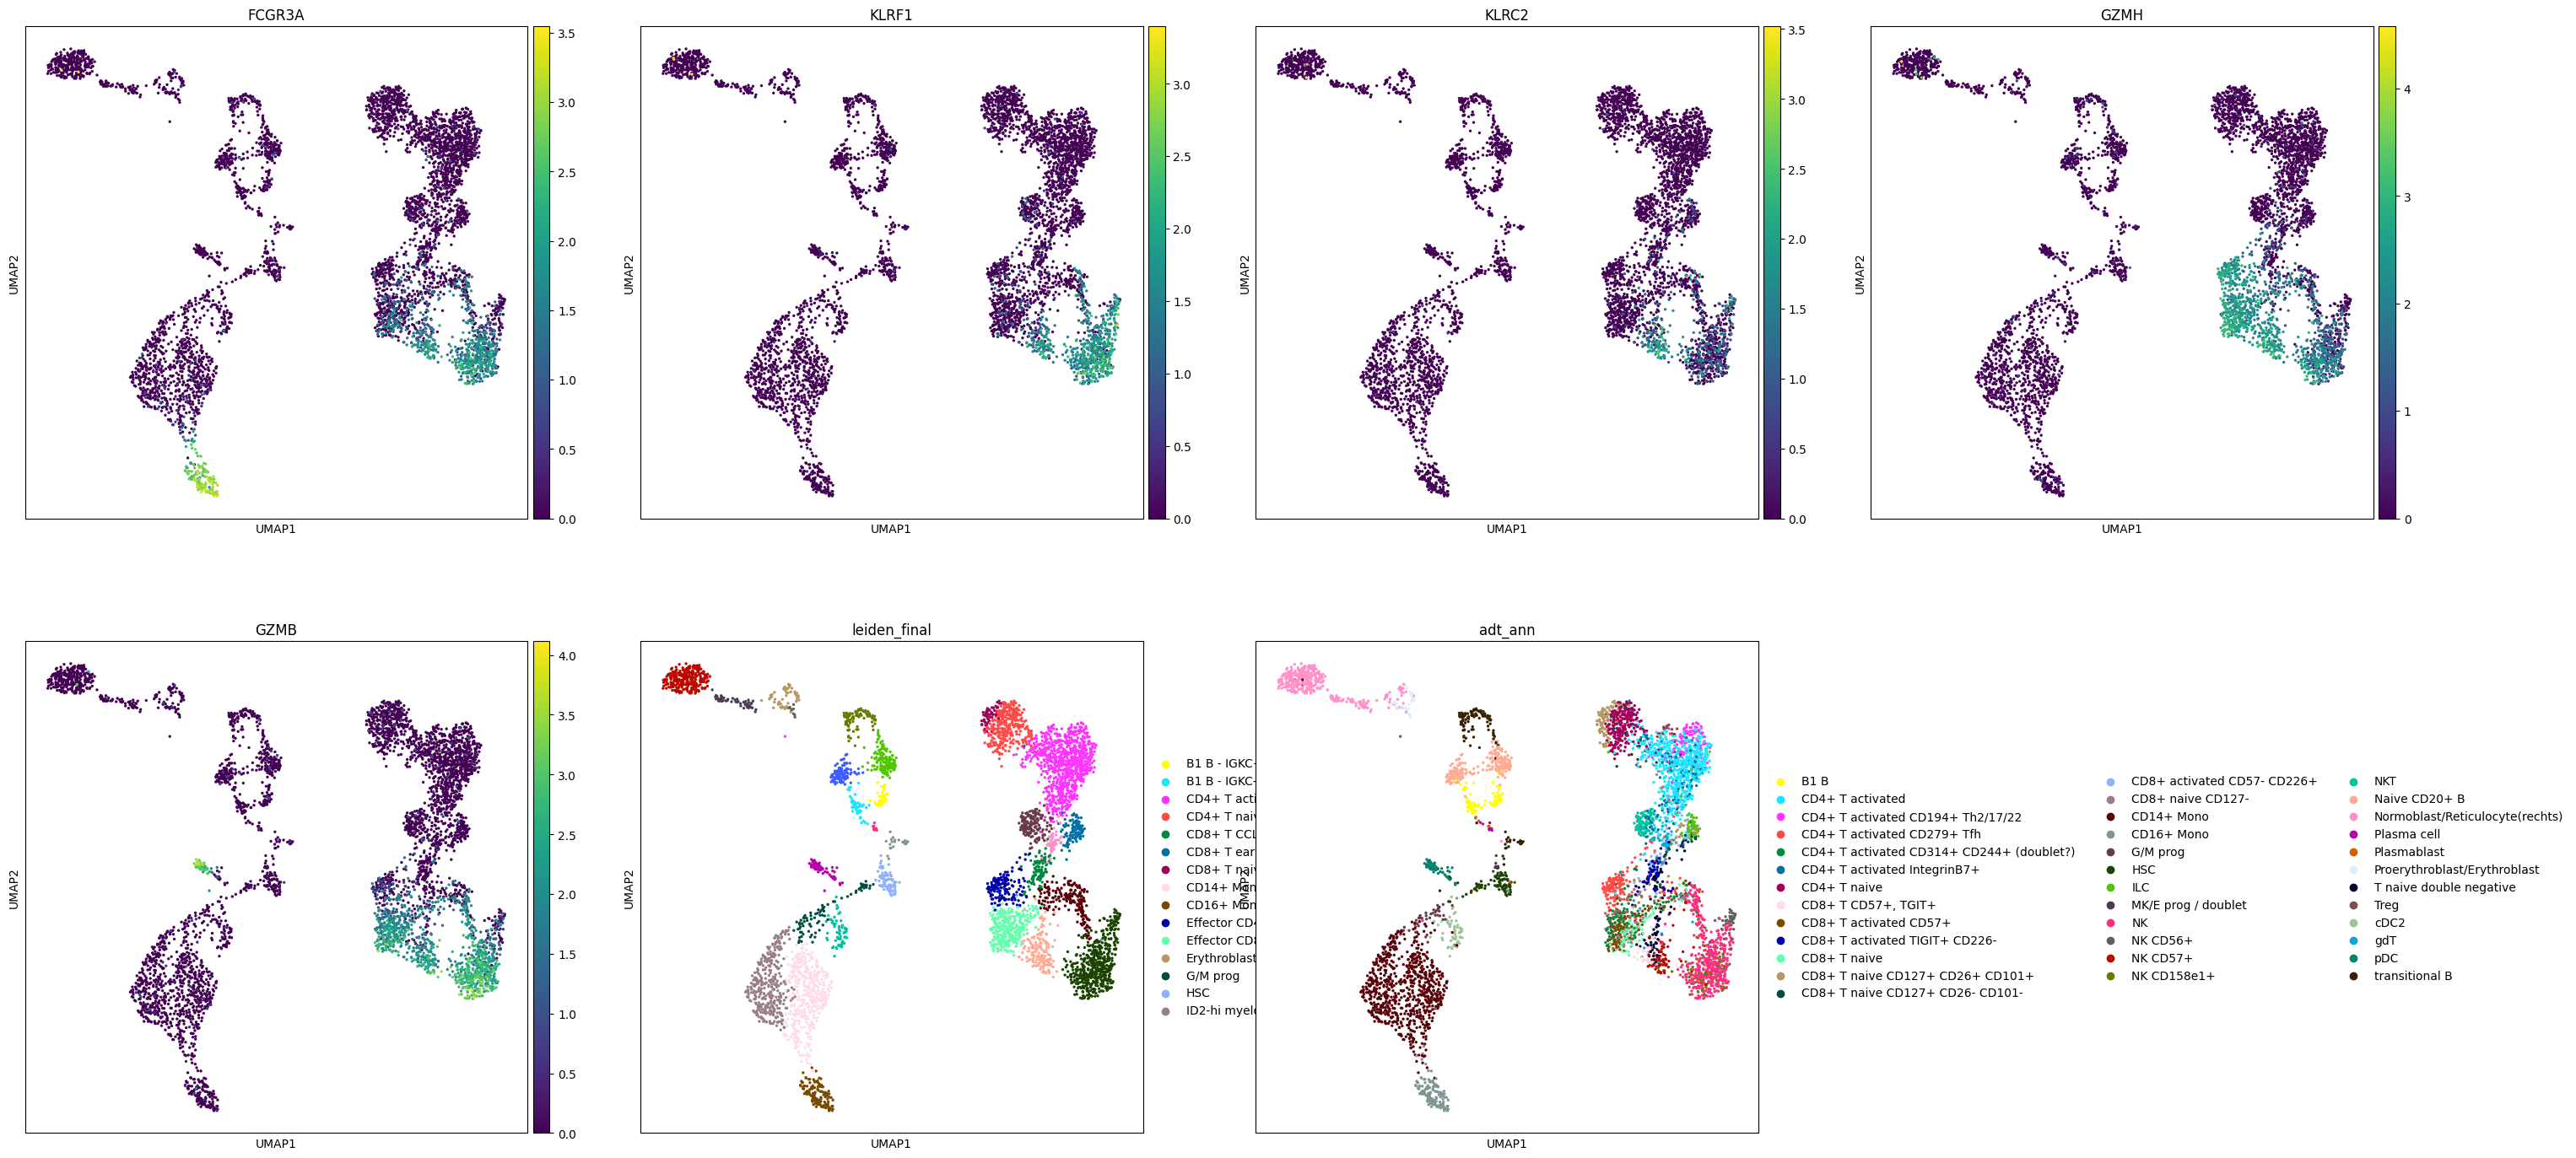

Markers on ADT


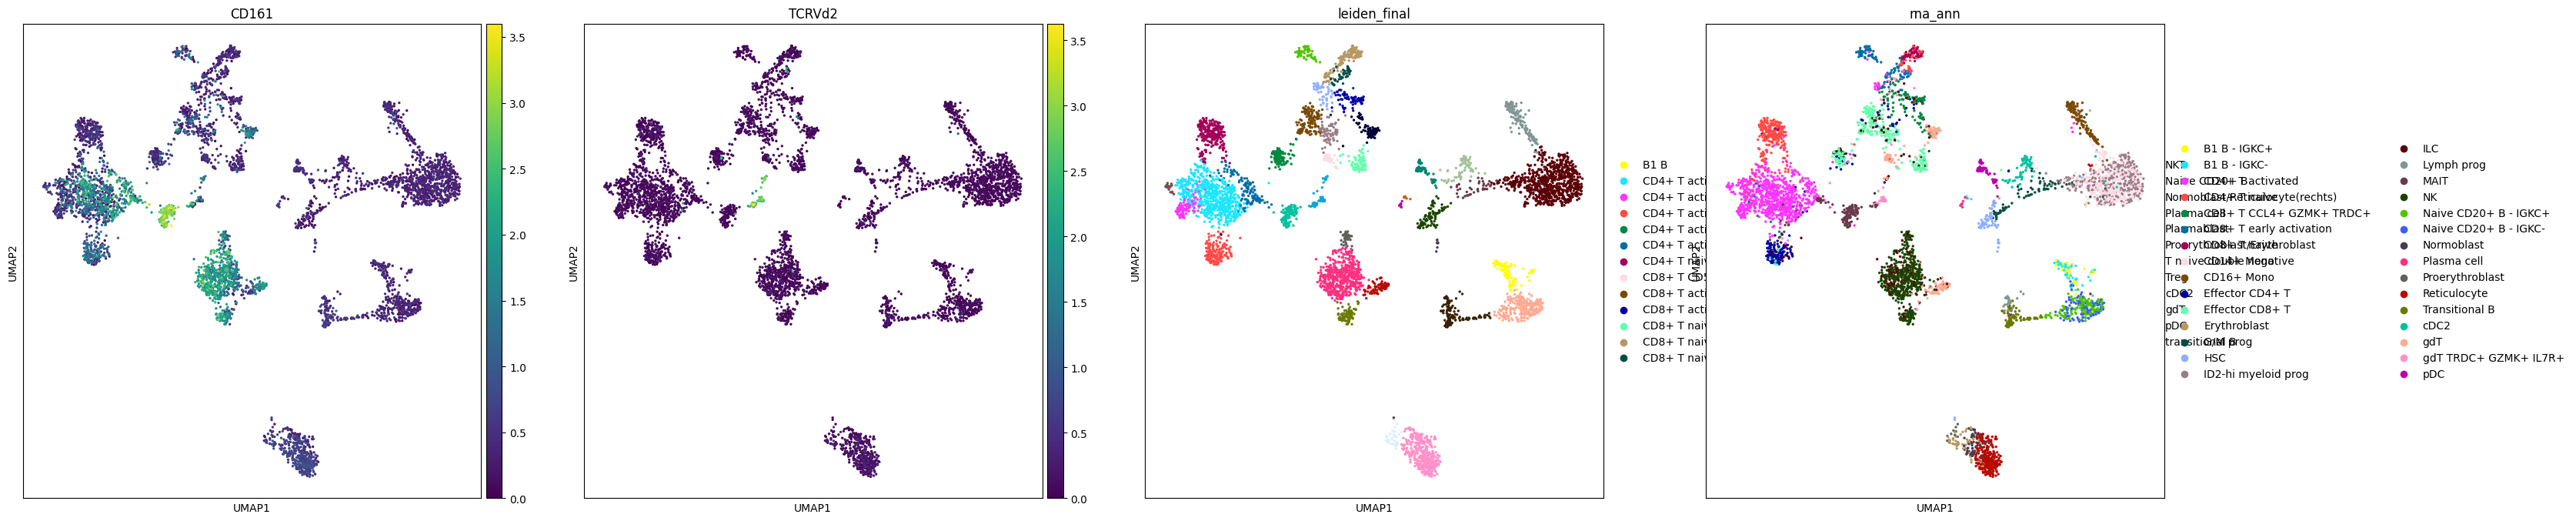

In [24]:
# select celltypes to compare
rna_ct = 'gdT'
adt_ct = 'gdT'

genes = marker_genes_rna[rna_ct]+marker_genes_adt[adt_ct]
ann_key_r = 'leiden_final'
ann_key_a = 'leiden_final'

genes_r = [g for g in adata_rna_sub.var_names if str(g) in genes ]
genes_a = [g for g in adata_adt_sub.var_names if str(g) in genes]

print('Markers on RNA')
sc.pl.umap(adata_rna_sub, color=genes_r+[ann_key_r, 'adt_ann'])

print('Markers on ADT')
sc.pl.umap(adata_adt_sub, color=genes_a+[ann_key_a, 'rna_ann'])

if len(genes) < 3:
    plt.rcParams['figure.figsize'] = (24,8)
    sc.pl.violin(adata_adt_sub, keys=genes_a, groupby=ann_key_a)
    plt.rcParams['figure.figsize'] = (8,8)

Additional highlighting of selected clusters (e.g. in case you can't identify particular clusters from the ADT or RNA plots due to bad coloring)

... storing 'test' as categorical


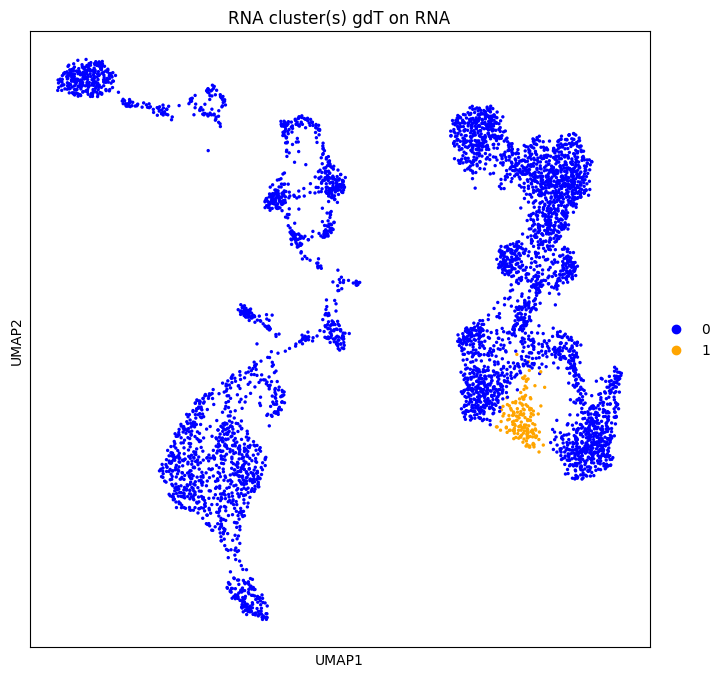

... storing 'test' as categorical


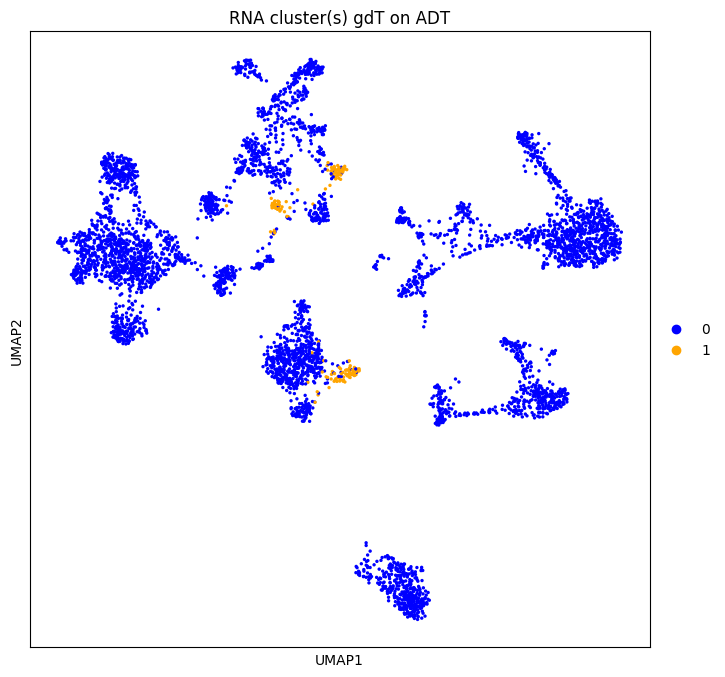

... storing 'test' as categorical


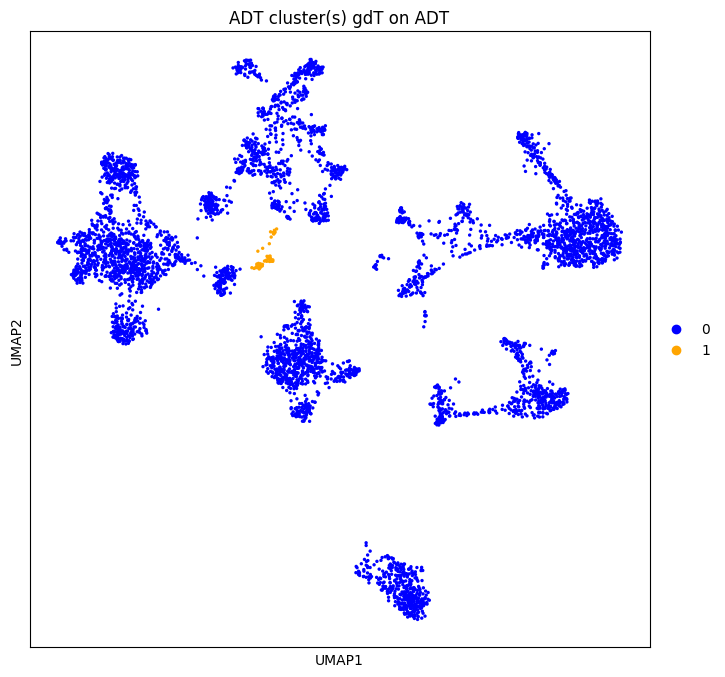

... storing 'test' as categorical


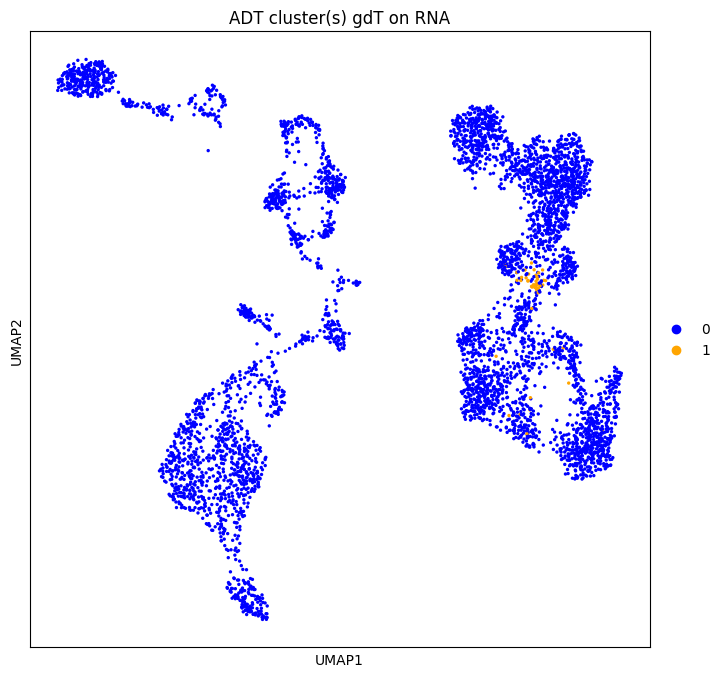

In [25]:
#RNA clusters
#-------------
# Use celltype from above
clusts = [rna_ct]
# Or selct new ones
#clusts = ['HSPC/Lymph prog?']

adata_rna_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_rna_sub.obs['leiden_final']]
sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'RNA cluster(s) '+ '; '.join(clusts) + ' on RNA')
adata_adt_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_adt_sub.obs['rna_ann']]
sc.pl.umap(adata_adt_sub, color='test', palette=['blue', 'orange'],
          title = 'RNA cluster(s) '+ '; '.join(clusts) + ' on ADT')


#ADT clusters
#--------------
# Use celltype from above
clusts = [adt_ct]
# Or selct new ones
#clusts = ['HSPC']

adata_adt_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_adt_sub.obs['leiden_final']]
sc.pl.umap(adata_adt_sub, color='test', palette=['blue', 'orange'],
          title = 'ADT cluster(s) '+ '; '.join(clusts) + ' on ADT')
adata_rna_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_rna_sub.obs['adt_ann']]
sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'ADT cluster(s) '+ '; '.join(clusts) + ' on RNA')



## Create a final merged celltype annotation

In [26]:
# List RNA celltypes
set(adata_rna_sub.obs['leiden_final'])

{'B1 B - IGKC+',
 'B1 B - IGKC-',
 'CD14+ Mono',
 'CD16+ Mono',
 'CD4+ T activated',
 'CD4+ T naive',
 'CD8+ T CCL4+ GZMK+ TRDC+',
 'CD8+ T early activation',
 'CD8+ T naive',
 'Effector CD4+ T',
 'Effector CD8+ T',
 'Erythroblast',
 'G/M prog',
 'HSC',
 'ID2-hi myeloid prog',
 'ILC',
 'Lymph prog',
 'MAIT',
 'NK',
 'Naive CD20+ B - IGKC+',
 'Naive CD20+ B - IGKC-',
 'Normoblast',
 'Plasma cell',
 'Proerythroblast',
 'Reticulocyte',
 'Transitional B',
 'cDC2',
 'gdT',
 'gdT TRDC+ GZMK+ IL7R+',
 'pDC'}

In [27]:
# List ADT celltypes
set(adata_adt_sub.obs['leiden_final'])

{'B1 B',
 'CD14+ Mono',
 'CD16+ Mono',
 'CD4+ T activated',
 'CD4+ T activated CD194+ Th2/17/22',
 'CD4+ T activated CD279+ Tfh',
 'CD4+ T activated CD314+ CD244+ (doublet?)',
 'CD4+ T activated IntegrinB7+',
 'CD4+ T naive',
 'CD8+ T CD57+, TGIT+',
 'CD8+ T activated CD57+',
 'CD8+ T activated TIGIT+ CD226-',
 'CD8+ T naive',
 'CD8+ T naive CD127+ CD26+ CD101+',
 'CD8+ T naive CD127+ CD26- CD101-',
 'CD8+ activated CD57- CD226+',
 'CD8+ naive CD127-',
 'G/M prog',
 'HSC',
 'ILC',
 'MK/E prog / doublet',
 'NK',
 'NK CD158e1+',
 'NK CD56+',
 'NK CD57+',
 'NKT',
 'Naive CD20+ B',
 'Normoblast/Reticulocyte(rechts)',
 'Plasma cell',
 'Plasmablast',
 'Proerythroblast/Erythroblast',
 'T naive double negative',
 'Treg',
 'cDC2',
 'gdT',
 'pDC',
 'transitional B'}

In [33]:
# Chose celltype from each modality:

celltype_map_rna = {
    'Naive CD20+ B - IGKC+':'Naive CD20+ B - IGKC+',
    'Naive CD20+ B - IGKC-':'Naive CD20+ B - IGKC-',
    'Transitional B':'Transitional B',
    'B1 B - IGKC+':'B1 B - IGKC+',
    'B1 B - IGKC-':'B1 B - IGKC-',

    'CD14+ Mono':'CD14+ Mono',
    'ID2-hi myeloid prog':'ID2-hi myeloid prog',
    'cDC2':'cDC2',    

    'Proerythroblast':'Proerythroblast',
    'Erythroblast':'Erythroblast',
    'Normoblast':'Normoblast',
    'Reticulocyte':'Reticulocyte',

    'HSC':'HSC',
    'G/M prog':'G/M prog',
    'Lymph prog':'Lymph prog',
}
celltype_map_adt = {

    'CD16+ Mono':'CD16+ Mono',
    'pDC':'pDC',

    'MK/E prog / doublet': 'MK/E prog',

    'Plasma cell':'Plasma cell',
    'Plasmablast':'Plasmablast',

    'NK CD158e1+': 'NK CD158e1+',
    'NK CD56+': 'gdT CD56+',
    'NK CD57+': 'gdT Vd1 CD57+',
    'gdT': 'gdT TCRVD2+',
    'T naive double negative':'gdT CD158b+ CD11c+',

    'CD4+ T naive': 'CD4+ T naive',
    'CD4+ T activated':'CD4+ T activated',
    'CD4+ T activated CD279+ Tfh': 'CD4+ T activated CD279+',
    'CD4+ T activated CD194+ Th2/17/22': 'CD4+ T activated CD194+',
    'CD4+ T activated IntegrinB7+':'CD4+ T activated integrinB7+',
    'CD4+ T activated CD314+ CD244+ (doublet?)': 'CD4+ T CD45RA+ CD314+',
    'Treg': 'T reg',
    'NKT': 'MAIT',

    'CD8+ T naive':'CD8+ T CD45RA+ CD56+',
    'CD8+ naive CD127-':'CD8+ T CD45RA+ CD127-',
    'CD8+ T activated CD57+':'CD8+ T activated CD57+',
    'CD8+ T CD57+, TGIT+': 'CD8+ T CD158b+ CD57+ TIGIT+',
    'CD8+ T naive CD127+ CD26+ CD101+':'CD8+ T naive CD127+ CD26+ CD101+',
    'CD8+ T naive CD127+ CD26- CD101-':'CD8+ T naive CD127+ CD26- CD101-',
    'CD8+ T activated TIGIT+ CD226-':'CD8+ T activated TIGIT+ CD226-',
    'CD8+ activated CD57- CD226+':'CD8+ T activated CD57- CD226+',
    'ILC': 'ILC1',
}

rna_cts = list(celltype_map_rna.keys())
adt_cts = list(celltype_map_adt.keys())

Create new colomn with selected celltypes and add **'Oh god'** for cells that are not part of one of the selected celltype clusters:

Need to also implement the combination plan for NK cells:

Combination:
- NK in ADT & ILC in RNA => ILC
- rest ILC in RNA -> low Quality!
- rest NK from ADT

In [34]:
new_celltype_ann = []

for idx in adata_rna_sub.obs_names:
    rna_ct = adata_rna_sub.obs['leiden_final'][idx]
    adt_ct = adata_adt_sub.obs['leiden_final'][idx]
    
    if adt_ct == 'NK':
        if rna_ct == 'ILC':
            new_celltype_ann.append('ILC')
        else:
            new_celltype_ann.append('NK')
    elif rna_ct == 'ILC':
        new_celltype_ann.append('to_remove')
    elif adt_ct in adt_cts:
        new_celltype_ann.append(celltype_map_adt[adt_ct])
    elif rna_ct in rna_cts:
        new_celltype_ann.append(celltype_map_rna[rna_ct])
    else:
        new_celltype_ann.append('Oh god')

final_ann_df = pd.Series(index=adata_rna_sub.obs_names, data=new_celltype_ann)        
        
adata_rna_sub.obs['celltype'] = final_ann_df
adata_adt_sub.obs['celltype'] = final_ann_df

In [35]:
# Number of cells per celltype
adata_rna_sub.obs['celltype'].value_counts()

CD4+ T activated                    640
NK                                  417
CD14+ Mono                          393
ID2-hi myeloid prog                 333
Reticulocyte                        279
CD4+ T naive                        259
Naive CD20+ B - IGKC+               150
CD4+ T activated CD279+             148
CD16+ Mono                          142
CD8+ T naive CD127+ CD26+ CD101+    129
CD4+ T activated integrinB7+        123
CD8+ T activated CD57+              119
to_remove                           112
Naive CD20+ B - IGKC-               112
MAIT                                107
CD4+ T activated CD194+             105
CD4+ T CD45RA+ CD314+                92
Transitional B                       90
ILC                                  83
G/M prog                             82
NK CD158e1+                          76
CD8+ T CD45RA+ CD56+                 72
gdT Vd1 CD57+                        72
gdT CD158b+ CD11c+                   69
pDC                                  67


Now we need to take a closer look at the **'Oh god'** cells.

We do so by checking the celltypes per modality, **'Oh god'** cells come from:

In [36]:
# Comparison of final celltypes with RNA celltypes
pd.crosstab(adata_rna_sub.obs['celltype'], adata_rna_sub.obs['leiden_final'])

leiden_final                      B1 B - IGKC+  B1 B - IGKC-  \
celltype                                                       
B1 B - IGKC+                                42             0   
B1 B - IGKC-                                 0            52   
CD14+ Mono                                   0             0   
CD16+ Mono                                   0             0   
CD4+ T CD45RA+ CD314+                        0             0   
CD4+ T activated                             0             0   
CD4+ T activated CD194+                      0             0   
CD4+ T activated CD279+                      0             0   
CD4+ T activated integrinB7+                 0             0   
CD4+ T naive                                 0             0   
CD8+ T CD158b+ CD57+ TIGIT+                  0             0   
CD8+ T CD45RA+ CD127-                        0             0   
CD8+ T CD45RA+ CD56+                         0             0   
CD8+ T activated CD57+                       0             0   
CD8+ T activated CD57- CD226+                0             0   
CD8+ T activated TIGIT+ CD226-               0             0   
CD8+ T naive CD127+ CD26+ CD101+             0             0   
CD8+ T naive CD127+ CD26- CD101-             0             0   
Erythroblast                                 0             0   
G/M prog                                     0             0   
HSC                                          0             0   
ID2-hi myeloid prog                          0             0   
ILC                                          0             0   
ILC1                                         0             0   
Lymph prog                                   0             0   
MAIT                                         0             0   
MK/E prog                                    0             0   
NK                                           0             0   
NK CD158e1+                                  0             0   
Naive CD20+ B - IGKC+                        0             0   
Naive CD20+ B - IGKC-                        0             0   
Normoblast                                   0             0   
Oh god                                       0             0   
Plasma cell                                  0             2   
Plasmablast                                  0             3   
Proerythroblast                              0             0   
Reticulocyte                                 0             0   
T reg                                        0             0   
Transitional B                               0             0   
cDC2                                         0             0   
gdT CD158b+ CD11c+                           0             0   
gdT CD56+                                    0             0   
gdT TCRVD2+                                  0             0   
gdT Vd1 CD57+                                0             0   
pDC                                          0             0   
to_remove                                    0             0   

leiden_final                      CD4+ T activated  CD4+ T naive  \
celltype                                                           
B1 B - IGKC+                                     0             0   
B1 B - IGKC-                                     0             0   
CD14+ Mono                                       0             0   
CD16+ Mono                                       3             0   
CD4+ T CD45RA+ CD314+                            3             1   
CD4+ T activated                               586            23   
CD4+ T activated CD194+                        105             0   
CD4+ T activated CD279+                          4             0   
CD4+ T activated integrinB7+                    94             7   
CD4+ T naive                                     9           244   
CD8+ T CD158b+ CD57+ TIGIT+                      0             0   
CD8+ T CD45RA+ CD127-                      

In [37]:
# Comparison of final celltypes with ADT celltypes
pd.crosstab(adata_adt_sub.obs['celltype'], adata_adt_sub.obs['leiden_final'])

leiden_final                      B1 B  CD4+ T activated  \
celltype                                                   
B1 B - IGKC+                        41                 0   
B1 B - IGKC-                        49                 0   
CD14+ Mono                           0                 0   
CD16+ Mono                           0                 0   
CD4+ T CD45RA+ CD314+                0                 0   
CD4+ T activated                     0               640   
CD4+ T activated CD194+              0                 0   
CD4+ T activated CD279+              0                 0   
CD4+ T activated integrinB7+         0                 0   
CD4+ T naive                         0                 0   
CD8+ T CD158b+ CD57+ TIGIT+          0                 0   
CD8+ T CD45RA+ CD127-                0                 0   
CD8+ T CD45RA+ CD56+                 0                 0   
CD8+ T activated CD57+               0                 0   
CD8+ T activated CD57- CD226+        0                 0   
CD8+ T activated TIGIT+ CD226-       0                 0   
CD8+ T naive CD127+ CD26+ CD101+     0                 0   
CD8+ T naive CD127+ CD26- CD101-     0                 0   
Erythroblast                         0                 0   
G/M prog                             0                 0   
HSC                                  0                 0   
ID2-hi myeloid prog                  0                 0   
ILC                                  0                 0   
ILC1                                 0                 0   
Lymph prog                           0                 0   
MAIT                                 0                 0   
MK/E prog                            0                 0   
NK                                   0                 0   
NK CD158e1+                          0                 0   
Naive CD20+ B - IGKC+                2                 0   
Naive CD20+ B - IGKC-                4                 0   
Normoblast                           0                 0   
Oh god                               0                 0   
Plasma cell                          0                 0   
Plasmablast                          0                 0   
Proerythroblast                      0                 0   
Reticulocyte                         0                 0   
T reg                                0                 0   
Transitional B                       0                 0   
cDC2                                 0                 0   
gdT CD158b+ CD11c+                   0                 0   
gdT CD56+                            0                 0   
gdT TCRVD2+                          0                 0   
gdT Vd1 CD57+                        0                 0   
pDC                                  0                 0   
to_remove                            0                 0   

leiden_final                      CD4+ T activated CD194+ Th2/17/22  \
celltype                                                              
B1 B - IGKC+                                                      0   
B1 B - IGKC-                                                      0   
CD14+ Mono                                                        0   
CD16+ Mono                                                        0   
CD4+ T CD45RA+ CD314+                                             0   
CD4+ T activated                                                  0   
CD4+ T activated CD194+                                         105   
CD4+ T activated CD279+                                           0   
CD4+ T activated integrinB7+                                      0   
CD4+ T naive                                                      0   
CD8+ T CD158b+ CD57+ TIGIT+                                       0   
CD8+ T CD45RA+ CD127-                                             0   
CD8+ T CD45RA+ CD56+                                              0   
CD8+ T activated CD57+                                

### Resolve unannotated cells

This includes
- Remaining clusters that were not included in final annotation at all (e.g. high count - T doublet from ADT, which we assign to CD4+ T naive (also given the RNA annotation)
- Subsets of clusters that were not defined in the final celltypes. It is helpful to check again where the unassigned cells might come from. Depending on whether an association with a certain celltype can be made, they should be labeled accordingly or be removed.

In [38]:
# Plot specific 'Oh god' cells

# in RNA
clust = ['CD16+ Mono', 'pDC']

test_vec_rna = []

for i,ct in enumerate(adata_rna_sub.obs['leiden_final']):
    
    if ct in clust:
        if adata_rna_sub.obs['celltype'][i]=='Oh god':
            test_vec_rna.append('1')
        else:
            test_vec_rna.append('0')
    else:
        test_vec_rna.append('0')

# in ADT
clust = ['CD14+ Mono', 'cDC2']
test_vec_adt = []

for i,ct in enumerate(adata_adt_sub.obs['leiden_final']):
    
    if ct in clust:
        if adata_adt_sub.obs['celltype'][i]=='Oh god':
            test_vec_adt.append('1')
        else:
            test_vec_adt.append('0')
    else:
        test_vec_adt.append('0')

... storing 'test' as categorical
... storing 'celltype' as categorical


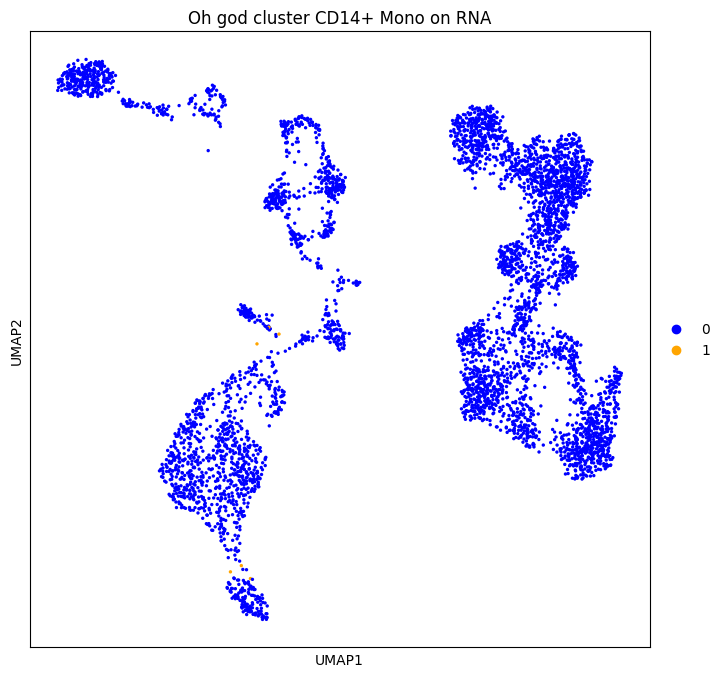

... storing 'test' as categorical
... storing 'celltype' as categorical


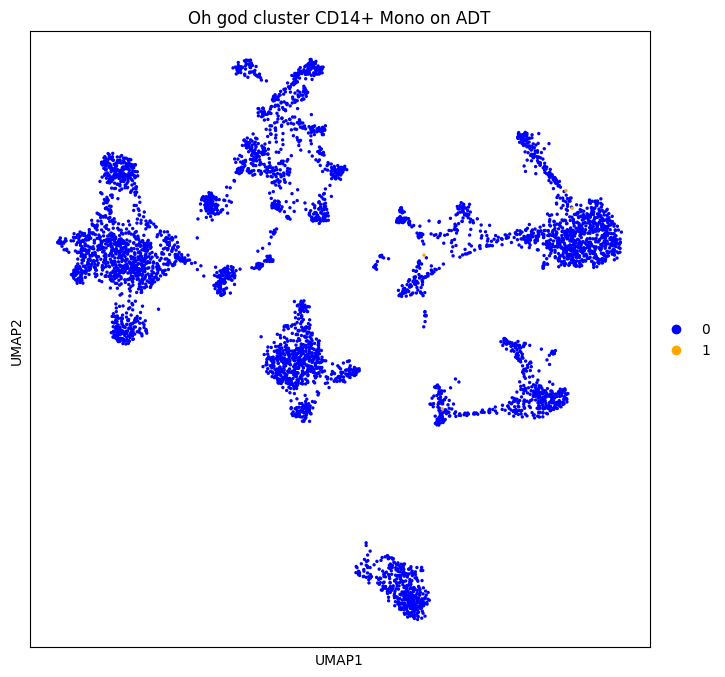

In [39]:
adata_rna_sub.obs['test'] = test_vec_rna
adata_adt_sub.obs['test'] = test_vec_rna

sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'Oh god cluster '+ clust[0] + ' on RNA')

sc.pl.umap(adata_adt_sub, color='test', palette=['blue', 'orange'],
          title = 'Oh god cluster '+ clust[0] + ' on ADT')

RNA:
- G/M prog / CD14+ Mono -> doublet? -> remove

- prog lowQ unclear... -> remove 

Add celltype for Oh god cells, where association is clear

In [40]:
# NOt applied in this one, but potentially helful for other

new_celltype_ann = []

for idx in adata_rna_sub.obs_names:
    given_ct = adata_rna_sub.obs['celltype'][idx]
    rna_ct = adata_rna_sub.obs['leiden_final'][idx]
    adt_ct = adata_adt_sub.obs['leiden_final'][idx]
    
    if given_ct == 'Oh god':
        #if adt_ct == 'transitional B - 1':
        #     new_celltype_ann.append('HSPC')
        # Below would be adding a label if celltype association is clear
        #elif rna_ct == 'G/M prog':
        #    new_celltype_ann.append('Lymph prog')
        else:
            new_celltype_ann.append('Oh god')
    else:
        new_celltype_ann.append(given_ct)

final_ann_df = pd.Series(index=adata_rna_sub.obs_names, data=new_celltype_ann)        
        
adata_rna_sub.obs['celltype'] = final_ann_df
adata_adt_sub.obs['celltype'] = final_ann_df

SyntaxError: invalid syntax (<ipython-input-40-654dd8d5f280>, line 16)

In [41]:
adata_rna_sub.obs['celltype'].value_counts()

CD4+ T activated                    640
NK                                  417
CD14+ Mono                          393
ID2-hi myeloid prog                 333
Reticulocyte                        279
CD4+ T naive                        259
Naive CD20+ B - IGKC+               150
CD4+ T activated CD279+             148
CD16+ Mono                          142
CD8+ T naive CD127+ CD26+ CD101+    129
CD4+ T activated integrinB7+        123
CD8+ T activated CD57+              119
to_remove                           112
Naive CD20+ B - IGKC-               112
MAIT                                107
CD4+ T activated CD194+             105
CD4+ T CD45RA+ CD314+                92
Transitional B                       90
ILC                                  83
G/M prog                             82
NK CD158e1+                          76
gdT Vd1 CD57+                        72
CD8+ T CD45RA+ CD56+                 72
gdT CD158b+ CD11c+                   69
pDC                                  67


### Remove unresolvable cells

Remove remaining Oh god cells

In [87]:
adata_rna_sub = adata_rna_sub[~adata_rna_sub.obs['celltype'].isin(['Oh god', 'to_remove'])].copy()
adata_adt_sub = adata_adt_sub[~adata_adt_sub.obs['celltype'].isin(['Oh god', 'to_remove'])].copy()

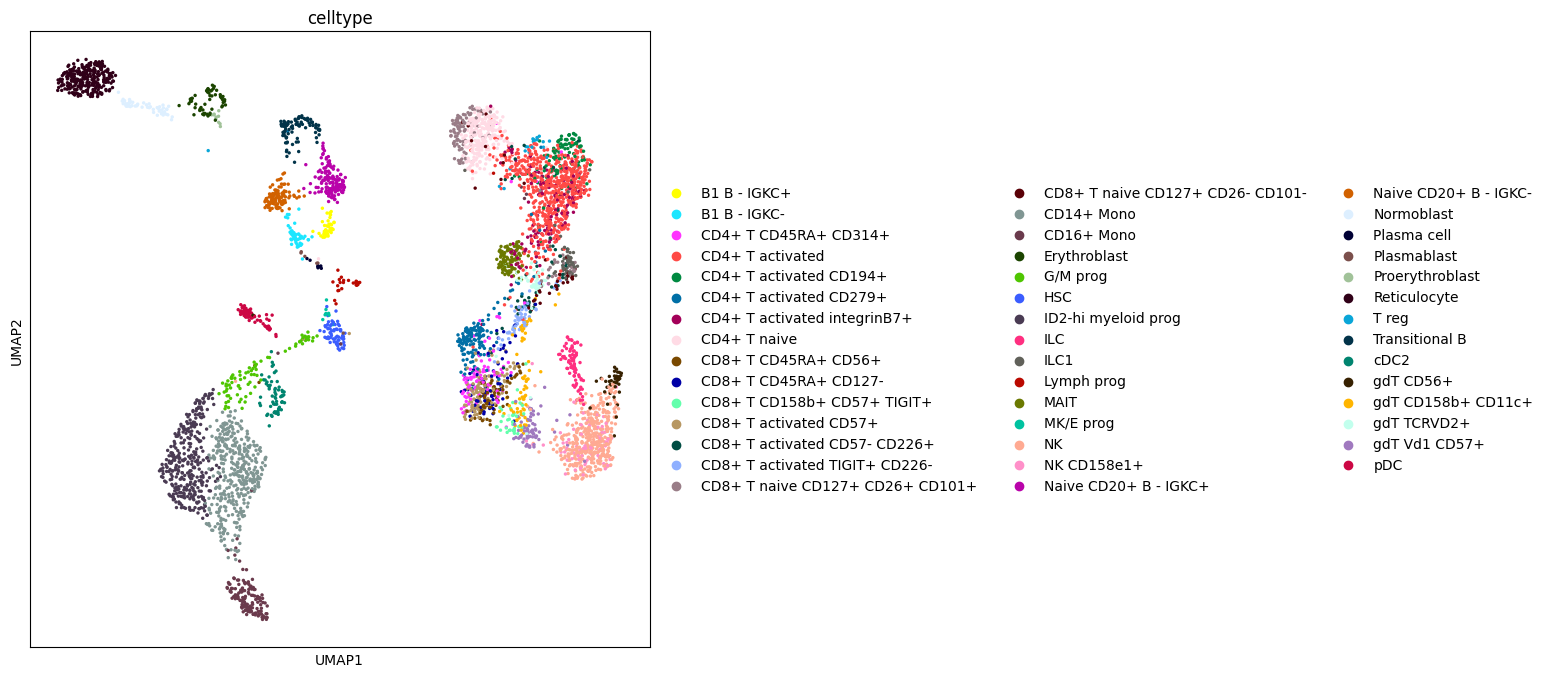

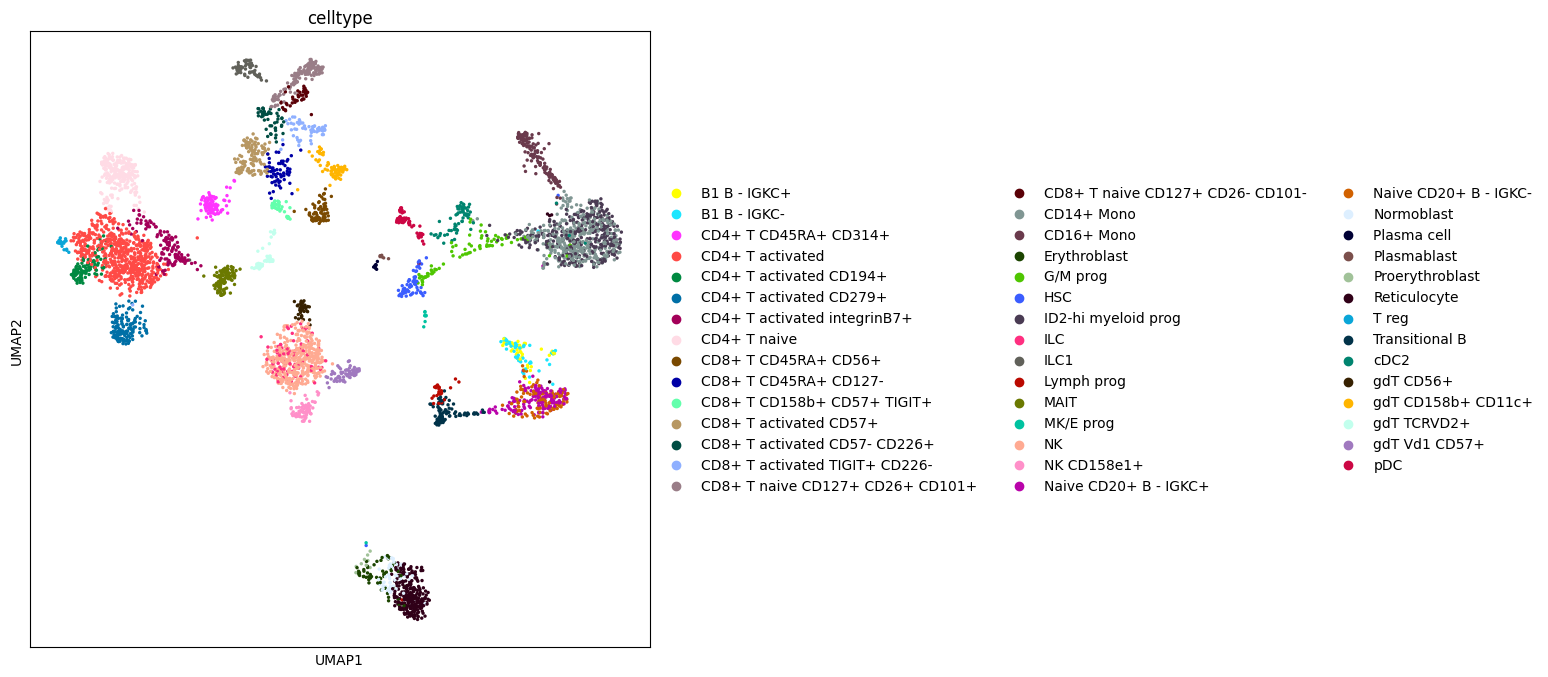

In [88]:
sc.pl.umap(adata_rna_sub, color='celltype')
sc.pl.umap(adata_adt_sub, color='celltype')

# Trajectories

## RNA Trajectory

In [89]:
adata_rna_sub.obs['celltype'].value_counts()

CD4+ T activated                    640
NK                                  417
CD14+ Mono                          393
ID2-hi myeloid prog                 333
Reticulocyte                        279
CD4+ T naive                        259
Naive CD20+ B - IGKC+               150
CD4+ T activated CD279+             148
CD16+ Mono                          142
CD8+ T naive CD127+ CD26+ CD101+    129
CD4+ T activated integrinB7+        123
CD8+ T activated CD57+              119
Naive CD20+ B - IGKC-               112
MAIT                                107
CD4+ T activated CD194+             105
CD4+ T CD45RA+ CD314+                92
Transitional B                       90
ILC                                  83
G/M prog                             82
NK CD158e1+                          76
gdT Vd1 CD57+                        72
CD8+ T CD45RA+ CD56+                 72
gdT CD158b+ CD11c+                   69
pDC                                  67
HSC                                  66


In [90]:
adata_rna_ery = adata_rna_sub[adata_rna_sub.obs['celltype'].isin(['HSC', 'MK/E prog', 'Proerythroblast', 'Erythroblast', 'Normoblast','Reticulocyte'])].copy()

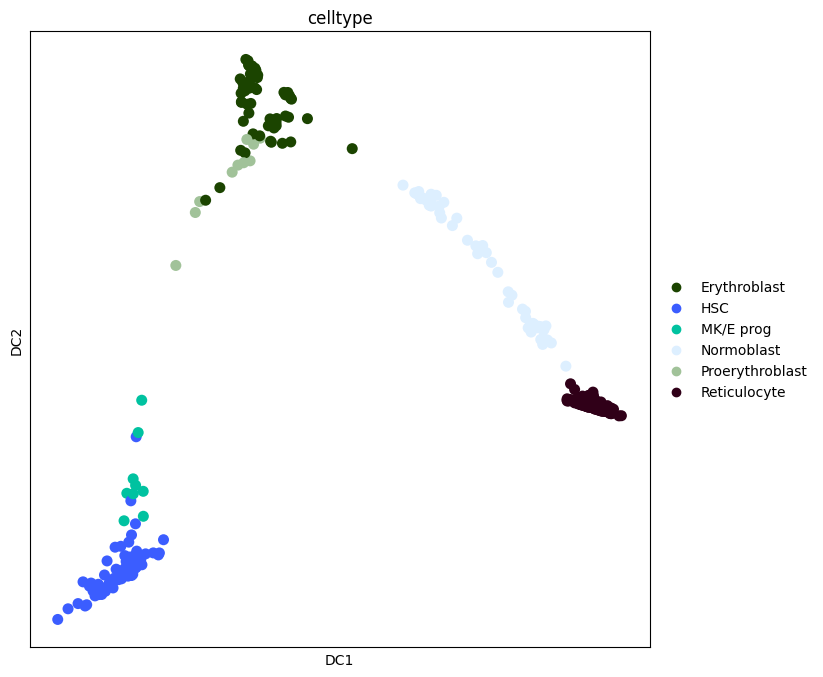

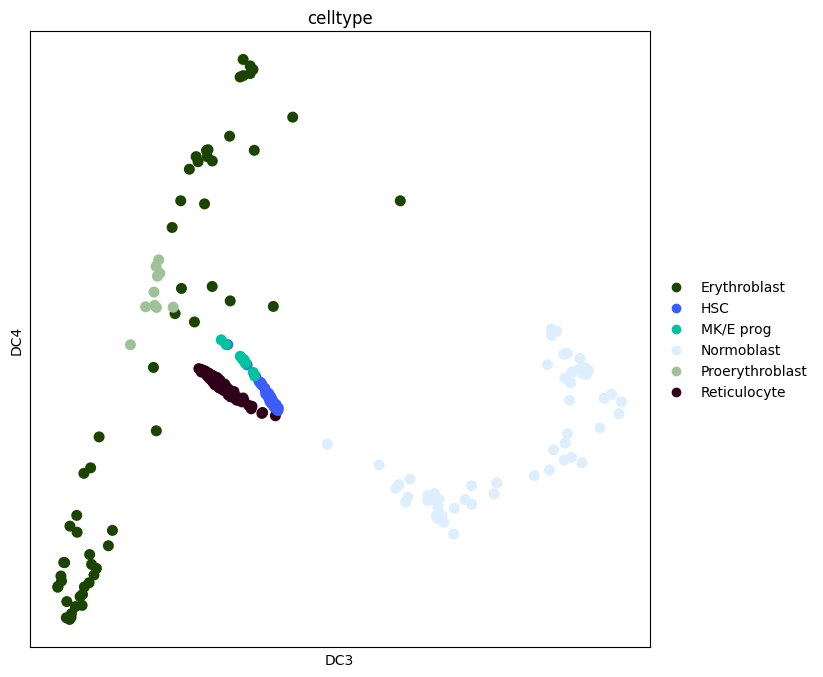

In [91]:
sc.pp.neighbors(adata_rna_ery)
sc.tl.diffmap(adata_rna_ery)
sc.pl.diffmap(adata_rna_ery, color='celltype', components='1,2', frameon=True)
sc.pl.diffmap(adata_rna_ery, color='celltype', components='3,4', frameon=True)

In [92]:
# Get DC1 min, DC2 max cell as root (most outer stem cell like cell)
# NOTE: argmax() or argmin() often needs to be reassigned for each run

c1 = adata_rna_ery.obsm['X_diffmap'][:,1].argmin()
c2 = c1 # adata_rna_ery.obsm['X_diffmap'][:,2].argmin()

correct root cell: TACCCGTGTAAGGCCA-1


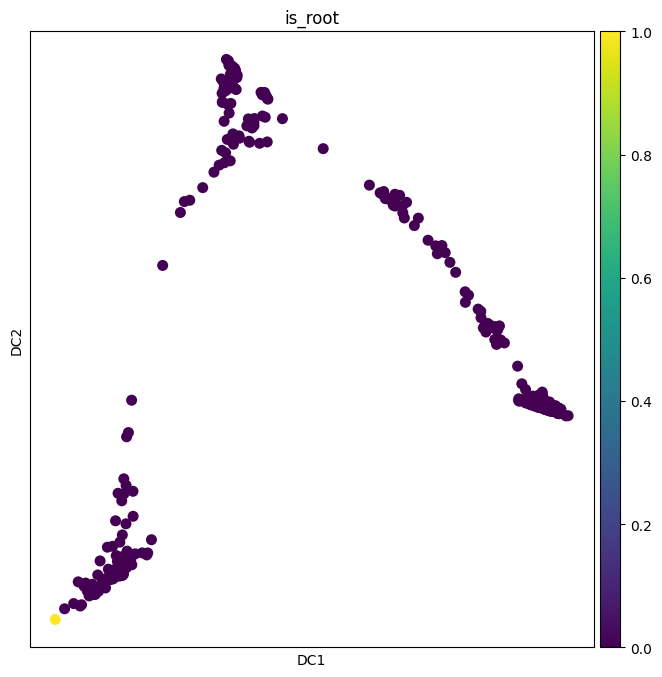

In [93]:
if c1 == c2:
    print(f'correct root cell: {adata_rna_ery.obs_names[c1]}')
    adata_rna_ery.uns['iroot'] = c1
    
    #check if correct
    adata_rna_ery.obs['is_root'] = [1 if idx==adata_rna_ery.obs_names[c1] else 0 for idx in adata_rna_ery.obs_names]
    sc.pl.diffmap(adata_rna_ery, color='is_root', components='1,2', frameon=True)
     

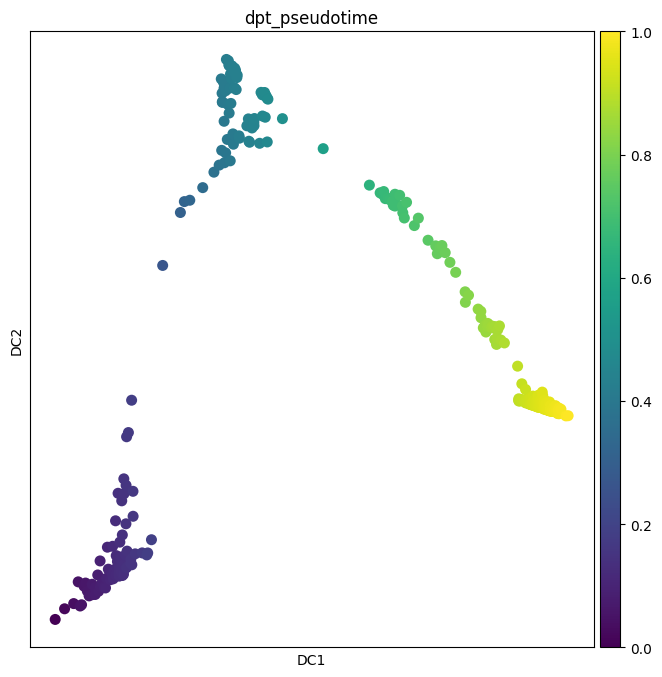

In [94]:
sc.tl.dpt(adata_rna_ery)
sc.pl.diffmap(adata_rna_ery, color='dpt_pseudotime', components='1,2', frameon=True)

In [95]:
# Transfer back to full object
adata_rna_sub.obs['pseudotime_order_GEX'] = adata_rna_ery.obs['dpt_pseudotime']

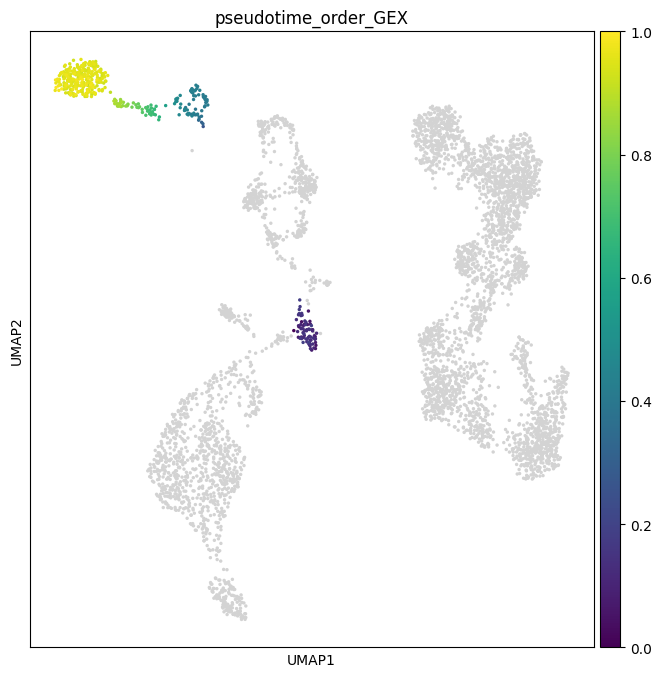

In [96]:
sc.pl.umap(adata_rna_sub, color='pseudotime_order_GEX')

## ADT Trajectory

In [97]:
adata_adt_sub.obs['celltype'].value_counts()

CD4+ T activated                    640
NK                                  417
CD14+ Mono                          393
ID2-hi myeloid prog                 333
Reticulocyte                        279
CD4+ T naive                        259
Naive CD20+ B - IGKC+               150
CD4+ T activated CD279+             148
CD16+ Mono                          142
CD8+ T naive CD127+ CD26+ CD101+    129
CD4+ T activated integrinB7+        123
CD8+ T activated CD57+              119
Naive CD20+ B - IGKC-               112
MAIT                                107
CD4+ T activated CD194+             105
CD4+ T CD45RA+ CD314+                92
Transitional B                       90
ILC                                  83
G/M prog                             82
NK CD158e1+                          76
gdT Vd1 CD57+                        72
CD8+ T CD45RA+ CD56+                 72
gdT CD158b+ CD11c+                   69
pDC                                  67
HSC                                  66


In [98]:
#adata_adt_ery = adata_adt_sub[adata_adt_sub.obs['celltype'].isin(['HSC', 'Proerythroblast', 'Erythroblast', 'Normoblast','Reticulocyte'])].copy()
adata_adt_ery = adata_adt_sub[adata_adt_sub.obs['celltype'].isin(['HSC', 'MK/E prog', 'Proerythroblast', 'Erythroblast', 'Normoblast','Reticulocyte'])].copy()

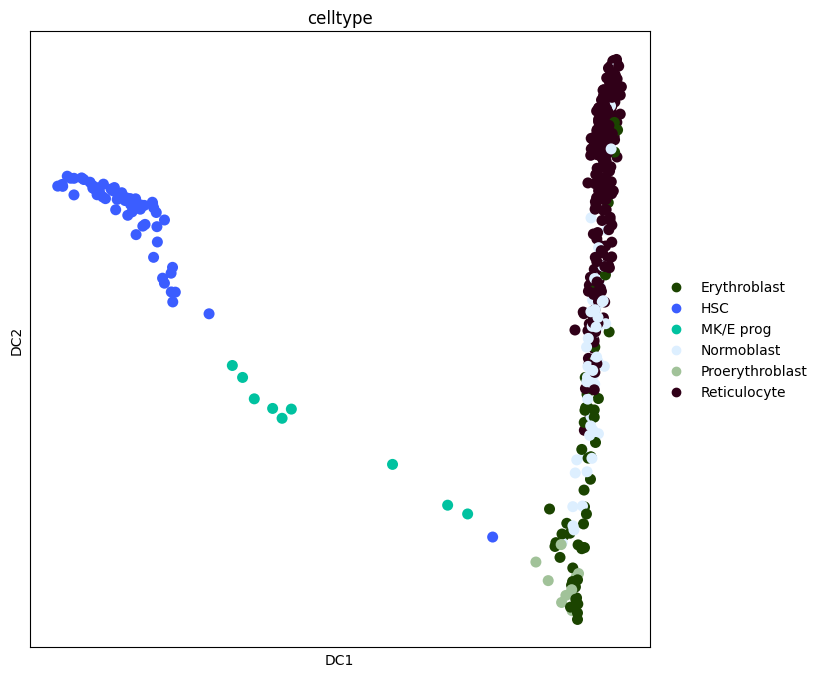

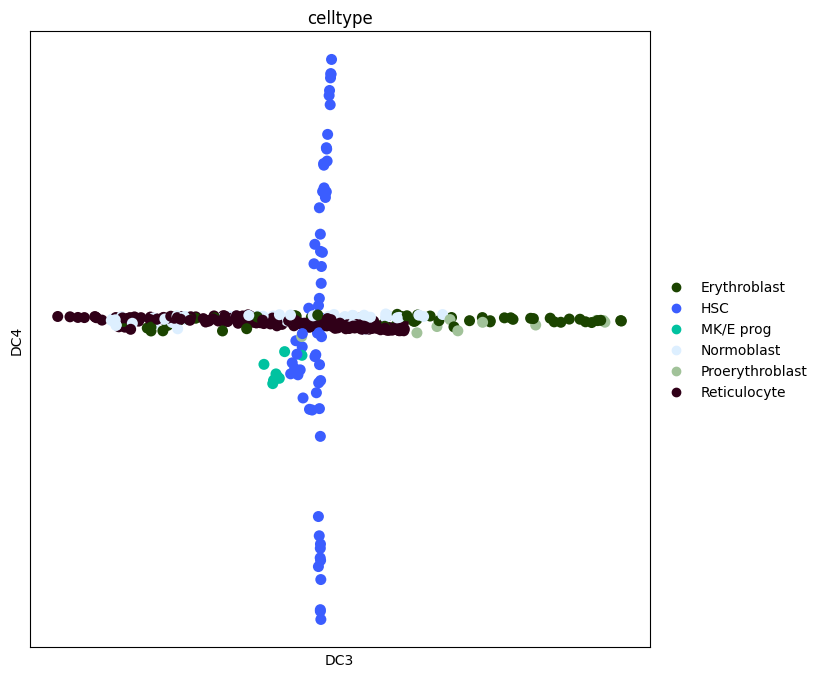

In [99]:
sc.pp.neighbors(adata_adt_ery)
sc.tl.diffmap(adata_adt_ery)
sc.pl.diffmap(adata_adt_ery, color='celltype', components='1,2', frameon=True)
sc.pl.diffmap(adata_adt_ery, color='celltype', components='3,4', frameon=True)

In [100]:
adata_adt_ery

AnnData object with n_obs × n_vars = 477 × 140
    obs: 'n_antibodies_by_counts', 'total_counts', 'iso_count', 'leiden_res0.5_sub', 'leiden_final', 'rna_ann', 'test', 'celltype', 'pseudotime_order_ADT'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'iso_count_fltr_colors', 'leiden', 'leiden_final_colors', 'leiden_res0.3_colors', 'leiden_res0.5_colors', 'leiden_res0.5_sub_colors', 'leiden_res0.8_colors', 'leiden_res1_colors', 'neighbors', 'pca', 'predicted_doublet_colors', 'rank_leiden_res0.5', 'rg_res0.5_sub', 'umap', 'rna_ann_colors', 'test_colors', 'celltype_colors', 'diffmap_evals'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

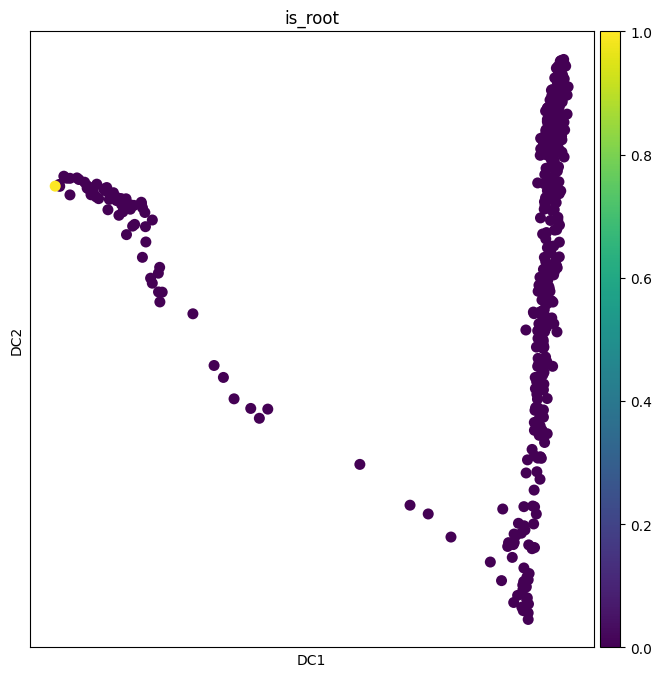

In [101]:
# Get DC1 min, DC2 max cell as root (should be the outer most stemm cell
c1 = adata_adt_ery.obsm['X_diffmap'][:,1].argmin()
#c2 = adata_adt_ery.obsm['X_diffmap'][:,2].argmax()

c2 = c1

adata_adt_ery.uns['iroot'] = c1

        
#check if correct
adata_adt_ery.obs['is_root'] = [1 if idx==adata_adt_ery.obs_names[c1] else 0 for idx in adata_adt_ery.obs_names]
sc.pl.diffmap(adata_adt_ery, color='is_root', components='1,2', frameon=True)


In [102]:
adata_adt_ery

AnnData object with n_obs × n_vars = 477 × 140
    obs: 'n_antibodies_by_counts', 'total_counts', 'iso_count', 'leiden_res0.5_sub', 'leiden_final', 'rna_ann', 'test', 'celltype', 'pseudotime_order_ADT', 'is_root'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'iso_count_fltr_colors', 'leiden', 'leiden_final_colors', 'leiden_res0.3_colors', 'leiden_res0.5_colors', 'leiden_res0.5_sub_colors', 'leiden_res0.8_colors', 'leiden_res1_colors', 'neighbors', 'pca', 'predicted_doublet_colors', 'rank_leiden_res0.5', 'rg_res0.5_sub', 'umap', 'rna_ann_colors', 'test_colors', 'celltype_colors', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

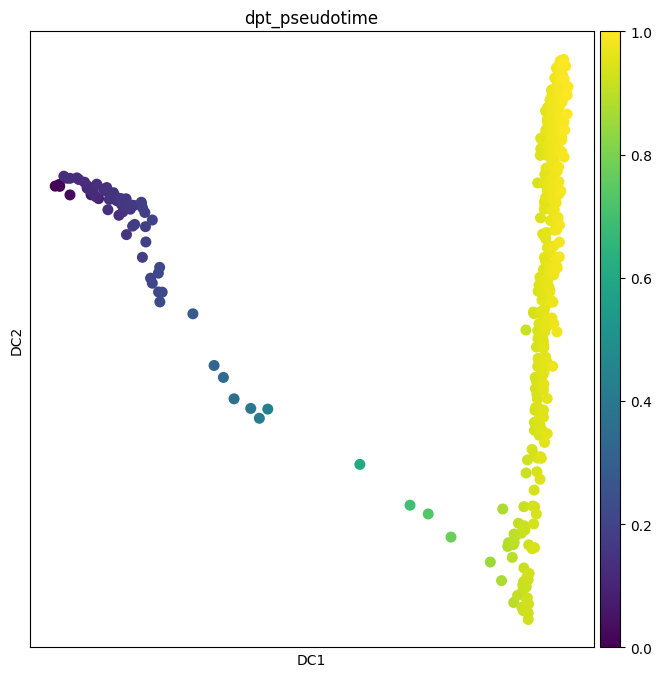

In [103]:
sc.tl.dpt(adata_adt_ery)
sc.pl.diffmap(adata_adt_ery, color='dpt_pseudotime', components='1,2', frameon=True)

In [104]:
# Transfer back to full object
adata_adt_sub.obs['pseudotime_order_ADT'] = adata_adt_ery.obs['dpt_pseudotime']

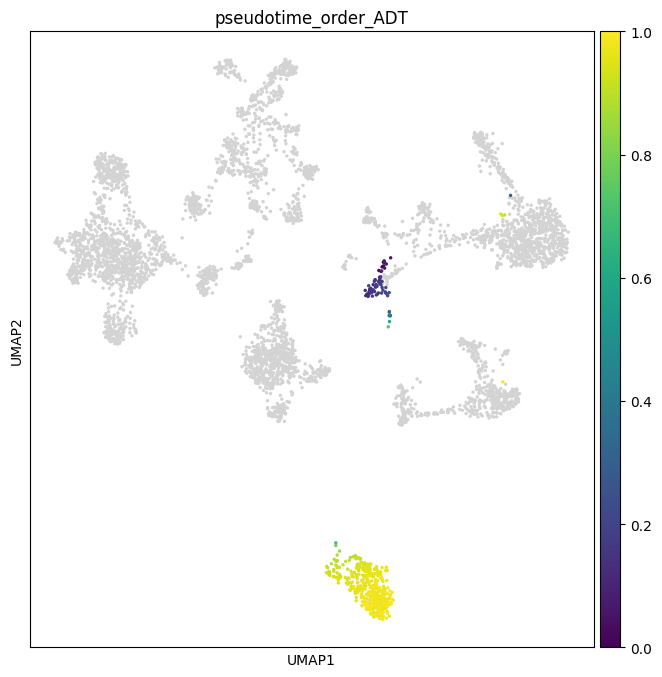

In [105]:
sc.pl.umap(adata_adt_sub, color='pseudotime_order_ADT')

## Write output

Save RNA data

In [106]:
# Check the object
adata_rna_sub

AnnData object with n_obs × n_vars = 4965 × 15508
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'size_factors', 'phase', 'leiden_final', 'adt_ann', 'test', 'celltype', 'pseudotime_order_GEX'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'neighbors', 'pca', 'umap', 'leiden_final_colors', 'adt_ann_colors', 'test_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [107]:
# Create slim rna adata
adata_rna_slim = ad.AnnData(X=adata_rna_sub.X,
                            obs=adata_rna_sub.obs[['n_genes_by_counts','pct_counts_mt','size_factors','phase',
                                                  'leiden_final','adt_ann','celltype','pseudotime_order_GEX']],
                           var=adata_rna_sub.var)

adata_rna_slim.obs = adata_rna_slim.obs.rename(columns={'celltype':'cell_type'})
adata_rna_slim.var['feature_types'] = 'GEX'

adata_rna_slim.uns = adata_rna_sub.uns
# remove colors in uns
col_labs = [lab for lab in list(adata_rna_slim.uns.keys()) if '_colors' in lab]
for col in col_labs:
    del(adata_rna_slim.uns[col])

adata_rna_slim.obsm = adata_rna_sub.obsm
adata_rna_slim.varm = adata_rna_sub.varm
adata_rna_slim.obsp = adata_rna_sub.obsp
adata_rna_slim.layers['counts'] = adata_rna_sub.layers['counts']

In [108]:
adata_rna_slim

AnnData object with n_obs × n_vars = 4965 × 15508
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'size_factors', 'phase', 'leiden_final', 'adt_ann', 'cell_type', 'pseudotime_order_GEX'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [109]:
# Save
adata_rna_slim.write_h5ad('data/cite/proc_data/s1d2/s1d2_gex_processed.h5ad')

... storing 'feature_types' as categorical


Save ADT data

In [110]:
# Check the object
adata_adt_sub

AnnData object with n_obs × n_vars = 4965 × 140
    obs: 'n_antibodies_by_counts', 'total_counts', 'iso_count', 'leiden_res0.5_sub', 'leiden_final', 'rna_ann', 'test', 'celltype', 'pseudotime_order_ADT'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'iso_count_fltr_colors', 'leiden', 'leiden_final_colors', 'leiden_res0.3_colors', 'leiden_res0.5_colors', 'leiden_res0.5_sub_colors', 'leiden_res0.8_colors', 'leiden_res1_colors', 'neighbors', 'pca', 'predicted_doublet_colors', 'rank_leiden_res0.5', 'rg_res0.5_sub', 'umap', 'rna_ann_colors', 'test_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [111]:
# Create slim adt adata
adata_adt_slim = ad.AnnData(X=adata_adt_sub.X,
                            obs=adata_adt_sub.obs[['n_antibodies_by_counts','total_counts','iso_count',
                                                  'leiden_final','rna_ann','celltype','pseudotime_order_ADT']],
                            var = pd.DataFrame(index=list(adata_adt_sub.var_names), 
                                               columns=['feature_types'], data = 'ADT')
                           )

adata_adt_slim.obs = adata_adt_slim.obs.rename(columns={'celltype':'cell_type'})

adata_adt_slim.uns = adata_adt_sub.uns
# remove colors in uns
col_labs = [lab for lab in list(adata_adt_slim.uns.keys()) if '_colors' in lab]
for col in col_labs:
    del(adata_adt_slim.uns[col])

adata_adt_slim.obsm = adata_adt_sub.obsm
adata_adt_slim.varm = adata_adt_sub.varm
adata_adt_slim.obsp = adata_adt_sub.obsp
adata_adt_slim.layers['counts'] = adata_adt_sub.layers['counts']

In [112]:
# Remove isotype controls
adata_adt_slim = adata_adt_slim[:,[i for i in adata_adt_slim.var_names if str(i) not in ['Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b', 'Rat-IgG1', 'Rat-IgG2a']]]

In [113]:
adata_adt_slim

View of AnnData object with n_obs × n_vars = 4965 × 134
    obs: 'n_antibodies_by_counts', 'total_counts', 'iso_count', 'leiden_final', 'rna_ann', 'cell_type', 'pseudotime_order_ADT'
    var: 'feature_types'
    uns: 'leiden', 'neighbors', 'pca', 'rank_leiden_res0.5', 'rg_res0.5_sub', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [114]:
adata_adt_slim.write_h5ad('data/cite/proc_data/s1d2/s1d2_adt_processed.h5ad')


/srv/conda/envs/saturn/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
